In [3]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
import time
from tensorflow.python.keras.utils import to_categorical

import shap
from tensorflow.python.ops import gradients_impl as tf_gradients_impl
tf_gradients_impl._IsBackpropagatable=True

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, losses
from tensorflow.python.keras.datasets import fashion_mnist
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from tensorflow.python.keras.layers import InputLayer
from sklearn.preprocessing import OneHotEncoder

from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input, Dense, Layer, InputSpec
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.constraints import UnitNorm, Constraint

In [19]:
class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
                
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis
        
    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = K.transpose(w)
        if(self.encoding_dim > 1):
            m = K.dot(K.transpose(w), w) - K.eye(self.encoding_dim)
            return self.weightage * K.sqrt(K.sum(K.square(m)))
        else:
            m = K.sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)
    
class UncorrelatedFeaturesConstraint(Constraint):
    
    def __init__(self, encoding_dim, weightage = 1.0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
    
    def get_covariance(self, x):
        x_centered_list = []

        for i in range(self.encoding_dim):
            x_centered_list.append(x[:, i] - K.mean(x[:, i]))
        
        x_centered = tf.stack(x_centered_list)
        covariance = K.dot(x_centered, K.transpose(x_centered)) / tf.cast(x_centered.get_shape()[0], tf.float32)
        
        return covariance
            
    # Constraint penalty
    def uncorrelated_feature(self, x):
        if(self.encoding_dim <= 1):
            return 0.0
        else:
            output = K.sum(K.square(
                self.covariance - tf.matmul(self.covariance, K.eye(self.encoding_dim))))
            # tf.math.multiply
            return output

    def __call__(self, x):
        self.covariance = self.get_covariance(x)
        return self.weightage * self.uncorrelated_feature(x)   
    
def extract_layers(main_model, starting_layer_ix, ending_layer_ix, input_shape):
  # create an empty model
    new_model = Sequential()
    first_layer =True
    for ix in range(starting_layer_ix, ending_layer_ix + 1):
        curr_layer = main_model.get_layer(index=ix)
        # copy this layer over to the new model
        if first_layer:
            new_model.add(input_shape)
            first_layer=False
        new_model.add(curr_layer)
    return new_model    

In [2]:
%%time
dataset_name = "W20_only"
df_list = "BES_Panel"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
# pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# # pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
# pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
# pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


Toggle code

var_type (463, 14)
Wall time: 3.67 s


In [196]:
# from tensorflow.python.keras.layers import Multiply

In [2]:
# import numpy as np
# import pandas as pd
# %matplotlib inline
# import matplotlib.pyplot as plt
# import gc
# import re

# from itertools import cycle
# from IPython.display import display
# import pickle, os

# import seaborn as sns

# encoding = "ISO-8859-1"

# import Jupyter_module_loader

In [3]:
# import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
# import pickle, os, gc, re

# from IPython.display import display

# import Jupyter_module_loader
# # from utility import *

In [1]:
%%time
dataset_name = "W10_only"
df_list = "BES_reduced"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


Toggle code

var_type (354, 13)
Wall time: 6.5 s


In [2]:
# warnings - don't know why, online comments suggest just blocking
# tf.logging.set_verbosity(tf.logging.ERROR)

In [31]:
drop_vars = []
drop_vars.extend( [x for x in BES_reduced.columns if "eurefvote" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "euid_" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "happyeuleave" in x.lower() ] )
drop_vars                 

['profile_eurefvote_Leave the EU',
 'euRefVote_Leave the EU',
 'euID_The leave side',
 'happyEULeave__Extremely happy']

In [32]:
# [x for x in BES_reduced.columns if "euref" in x.lower()]
y = BES_reduced['euRefVote_Leave the EU']
X = BES_reduced.drop(drop_vars,axis=1)
y = to_categorical(y)

In [18]:
# X.shape

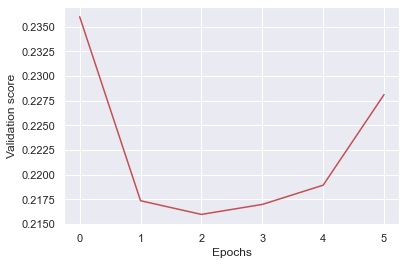

97.09109139442444


In [33]:
start_time = time.time()

early_stopping_monitor = EarlyStopping(patience=3)

n_neurons_layer = 500

# Create the model: model
model = Sequential()

# Add the first hidden layer
input_shape = (X.shape[1],)
model.add( Dense(n_neurons_layer, activation='relu', input_shape = input_shape) )

# Add the second hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the third hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the fourth hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the output layer
no_of_outputs = len(np.unique(y))
model.add( Dense( no_of_outputs , activation='softmax') )

# Compile the model
model.compile( optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Fit the model
# X -> X.values
model_training = model.fit(X.values, y, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)

# Create the plot
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

elapsed_time = time.time() - start_time
print(elapsed_time)

In [36]:
%%time

# hasattr(tf_gradients_impl, "_IsBackpropagatable")
background = X.loc[np.random.choice(X.shape[0], 200, replace=False)]

# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background.values)

Wall time: 1min 12s


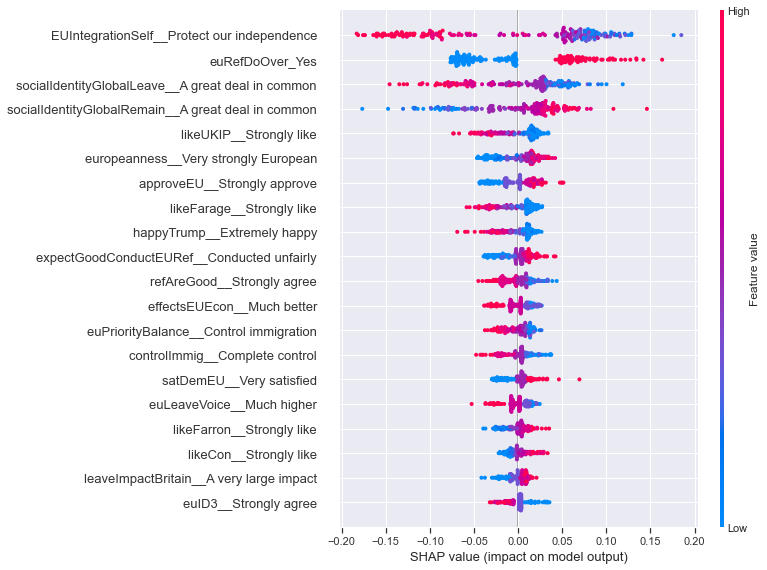

Wall time: 606 ms


In [37]:
%%time
shap.summary_plot(shap_values[0], background, plot_type='dot')

In [38]:
X.shape

(30319, 328)

In [39]:
y.shape

(30319, 2)

In [40]:
X

,turnoutUKGeneral__Very likely that I will vote,generalElectionCertainty__Completely certain,partyIdStrength__Not very strong,expectGoodConductEURef__Conducted unfairly,polAttention__Pay a great deal of attention,britishness__Very strongly British,englishness__Very strongly English,europeanness__Very strongly European,likeMay__Strongly like,likeCorbyn__Strongly like,...,expectAccess_Yes,negotiationSpecifics_none_Yes,negotiationSpecifics_3_Yes,negotiationSpecifics_2_Yes,negotiationSpecifics_1_Yes,bestPM_Jeremy Corbyn,profile_eurefturnout_Yes,gender_Female,euRefDoOver_Yes,regretsIHaveAFewEU_Yes
0,4.0,6.0,0.0,0.0,7.0,3.0,6.0,0.0,4.0,0.0,...,0,0,1,1,1,0,1,0,0,0
1,4.0,5.0,1.0,0.0,8.0,4.0,4.0,3.0,7.0,1.0,...,0,0,1,1,1,0,1,1,0,0
2,3.0,6.0,2.0,3.0,8.0,5.0,4.0,2.0,5.0,2.0,...,0,0,1,0,1,0,1,1,0,0
3,4.0,6.0,0.0,4.0,5.0,5.0,0.0,4.0,0.0,10.0,...,0,0,1,1,1,1,1,0,1,0
4,4.0,5.0,1.0,0.0,9.0,6.0,6.0,4.0,8.0,0.0,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30314,4.0,3.0,1.0,4.0,5.0,5.0,4.0,4.0,3.0,8.0,...,0,0,1,1,1,1,1,1,1,0
30315,1.0,6.0,1.0,2.0,1.0,3.0,3.0,3.0,5.0,2.0,...,0,0,1,1,1,0,1,1,0,0
30316,3.0,3.0,2.0,0.0,5.0,6.0,6.0,3.0,8.0,4.0,...,0,0,1,1,1,0,1,1,0,0
30317,3.0,6.0,1.0,3.0,4.0,3.0,5.0,3.0,5.0,6.0,...,0,0,0,0,1,1,1,0,1,0


In [41]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [42]:
X

,turnoutUKGeneral__Very likely that I will vote,generalElectionCertainty__Completely certain,partyIdStrength__Not very strong,expectGoodConductEURef__Conducted unfairly,polAttention__Pay a great deal of attention,britishness__Very strongly British,englishness__Very strongly English,europeanness__Very strongly European,likeMay__Strongly like,likeCorbyn__Strongly like,...,expectAccess_Yes,negotiationSpecifics_none_Yes,negotiationSpecifics_3_Yes,negotiationSpecifics_2_Yes,negotiationSpecifics_1_Yes,bestPM_Jeremy Corbyn,profile_eurefturnout_Yes,gender_Female,euRefDoOver_Yes,regretsIHaveAFewEU_Yes
0,4.0,6.0,0.0,0.0,7.0,3.0,6.0,0.0,4.0,0.0,...,0,0,1,1,1,0,1,0,0,0
1,4.0,5.0,1.0,0.0,8.0,4.0,4.0,3.0,7.0,1.0,...,0,0,1,1,1,0,1,1,0,0
2,3.0,6.0,2.0,3.0,8.0,5.0,4.0,2.0,5.0,2.0,...,0,0,1,0,1,0,1,1,0,0
3,4.0,6.0,0.0,4.0,5.0,5.0,0.0,4.0,0.0,10.0,...,0,0,1,1,1,1,1,0,1,0
4,4.0,5.0,1.0,0.0,9.0,6.0,6.0,4.0,8.0,0.0,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30314,4.0,3.0,1.0,4.0,5.0,5.0,4.0,4.0,3.0,8.0,...,0,0,1,1,1,1,1,1,1,0
30315,1.0,6.0,1.0,2.0,1.0,3.0,3.0,3.0,5.0,2.0,...,0,0,1,1,1,0,1,1,0,0
30316,3.0,3.0,2.0,0.0,5.0,6.0,6.0,3.0,8.0,4.0,...,0,0,1,1,1,0,1,1,0,0
30317,3.0,6.0,1.0,3.0,4.0,3.0,5.0,3.0,5.0,6.0,...,0,0,0,0,1,1,1,0,1,0


In [3]:
%%time
dataset_name = "W20_only"
df_list = "BES_reduced|BES_Panel"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
# pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# # pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
# pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
# pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


Toggle code

var_type (463, 14)
Wall time: 3.94 s


In [9]:
drop_vars = []
drop_vars.extend( [x for x in BES_reduced.columns if "euref" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "euid_" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "happyeuleave" in x.lower() ] )
# drop_vars.extend( [x for x in BES_reduced.columns if "euref" in x.lower() ] )


drop_vars                 

['p_eurefvote_I voted to leave',
 'p_eurefturnout_Yes',
 'euRefVoteAfter_Stay out of the EU',
 'euID_The leave side']

In [4]:
y = BES_reduced['p_eurefvote_I voted to leave']
y = to_categorical(y)
X = BES_reduced
#.drop(drop_vars,axis=1)

# X = X[["EUIntegrationSelf__Protect our independence"]]

In [80]:
# X = X.reset_index(drop=True)

In [62]:
BES_reduced['p_eurefvote_I voted to leave'].value_counts(dropna=False)

0    18333
1    13135
Name: p_eurefvote_I voted to leave, dtype: int64

In [67]:
search(X,"EUIntegrationSelf")

EUIntegrationSelf__Protect our independence    31468
dtype: int64

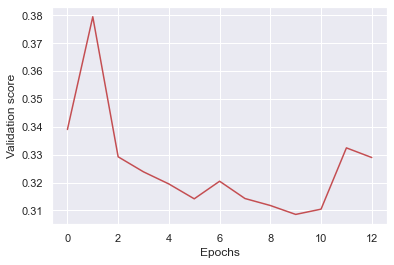

277.89589500427246


In [81]:
start_time = time.time()

early_stopping_monitor = EarlyStopping(patience=3)

n_neurons_layer = 500

# Create the model: model
model = Sequential()

# Add the first hidden layer
input_shape = (X.shape[1],)
model.add( Dense(n_neurons_layer, activation='relu', input_shape = input_shape) )

# Add the second hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the third hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the fourth hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the output layer
no_of_outputs = len(np.unique(y))
model.add( Dense( no_of_outputs , activation='softmax') )

# Compile the model
model.compile( optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Fit the model
# X -> X.values
model_training = model.fit(X.values, y, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)

# Create the plot
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

elapsed_time = time.time() - start_time
print(elapsed_time)

In [82]:
# %%time

# hasattr(tf_gradients_impl, "_IsBackpropagatable")
background = X.loc[X.index[np.random.choice(X.shape[0], 200, replace=False)]]

# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
e = shap.DeepExplainer(model, background.values)
shap_values = e.shap_values(background.values)

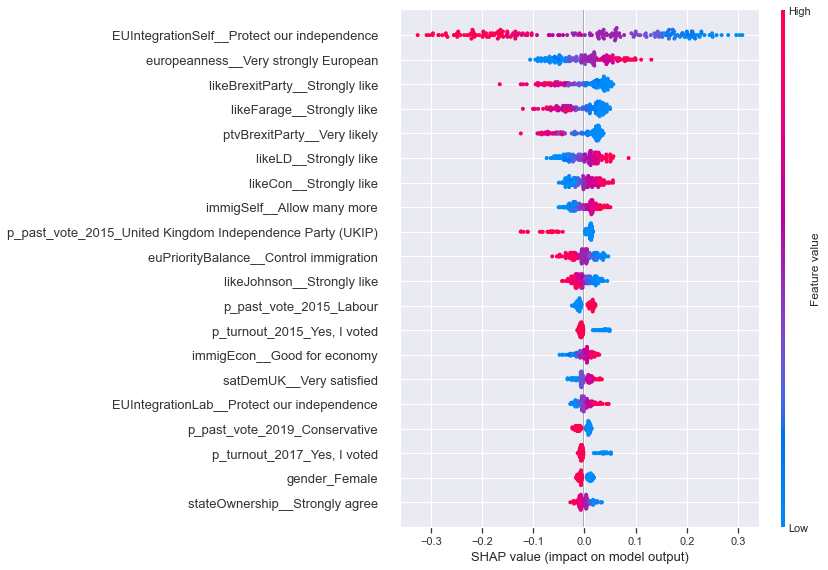

Wall time: 634 ms


In [83]:
%%time
shap.summary_plot(shap_values[0], background, plot_type='dot')

In [106]:
X.shape[1]

738

In [6]:
search(BES_reduced,"euRef")

p_eurefvote_I voted to leave         31468
p_eurefturnout_Yes                   31468
euRefVoteAfter_Stay out of the EU    31468
dtype: int64

In [77]:
BES_reduced.corrwith( BES_reduced['p_eurefvote_I voted to leave'] ).sort_values().head(10)

europeanness__Very strongly European    -0.505684
immigSelf__Allow many more              -0.494151
immigCultural__Enriches cultural life   -0.476114
immigEcon__Good for economy             -0.443282
likeLD__Strongly like                   -0.423664
likeLab__Strongly like                  -0.407686
ptvLD__Very likely                      -0.406763
ptvLab__Very likely                     -0.398804
likeGrn__Strongly like                  -0.382075
likeStarmer__Strongly like              -0.346852
dtype: float64

In [104]:
# # (x_train, _), (x_test, _) = fashion_mnist.load_data()

# from tensorflow.python.keras._impl.keras.datasets.mnist import load_data
# (x_train, _), (x_test, _) = load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.

# print (x_train.shape)
# print (x_test.shape)

In [103]:
# latent_dim = 64 

# class Autoencoder(Model):
#   def __init__(self, latent_dim):
#     super(Autoencoder, self).__init__()
#     self.latent_dim = latent_dim   
#     self.encoder = tf.keras.Sequential([
#       layers.Flatten(),
#       layers.Dense(latent_dim, activation='relu'),
#     ])
#     self.decoder = tf.keras.Sequential([
#       layers.Dense(784, activation='sigmoid'),
#       layers.Reshape((28, 28))
#     ])

#   def call(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

# autoencoder = Autoencoder(latent_dim)

# autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 4s - loss: 0.3705 - val_loss: 0.2721
Epoch 2/50
 - 4s - loss: 0.2647 - val_loss: 0.2538
Epoch 3/50
 - 4s - loss: 0.2433 - val_loss: 0.2305
Epoch 4/50
 - 4s - loss: 0.2225 - val_loss: 0.2124
Epoch 5/50
 - 4s - loss: 0.2069 - val_loss: 0.1991
Epoch 6/50
 - 4s - loss: 0.1955 - val_loss: 0.1893
Epoch 7/50
 - 4s - loss: 0.1868 - val_loss: 0.1816
Epoch 8/50
 - 4s - loss: 0.1798 - val_loss: 0.1752
Epoch 9/50
 - 4s - loss: 0.1739 - val_loss: 0.1697
Epoch 10/50
 - 4s - loss: 0.1687 - val_loss: 0.1648
Epoch 11/50
 - 4s - loss: 0.1641 - val_loss: 0.1604
Epoch 12/50
 - 4s - loss: 0.1598 - val_loss: 0.1563
Epoch 13/50
 - 3s - loss: 0.1560 - val_loss: 0.1527
Epoch 14/50
 - 4s - loss: 0.1524 - val_loss: 0.1492
Epoch 15/50
 - 4s - loss: 0.1491 - val_loss: 0.1460
Epoch 16/50
 - 4s - loss: 0.1461 - val_loss: 0.1431
Epoch 17/50
 - 4s - loss: 0.1434 - val_loss: 0.1406
Epoch 18/50
 - 4s - loss: 0.1408 - val_loss: 0.13

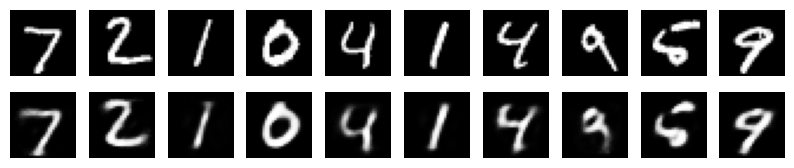

In [101]:


# Single fully-connected neural layer as encoder and decoder
use_regularizer = False
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l1(10e-8)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

# this is the size of our encoded representations
encoding_dim = 32   # 32 floats -> compression factor 24.5, assuming the input is 784 floats

# this is our input placeholder; 784 = 28 x 28
input_img = Input(shape=(784, ))

# "encoded" is the encoded representation of the inputs
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=my_regularizer)(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# Separate Encoder model

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# Separate Decoder model

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Train to reconstruct MNIST digits

# configure model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# prepare input data
(x_train, _), (x_test, y_test) = mnist.load_data()

# normalize all values between 0 and 1 and flatten the 28x28 images into vectors of size 784
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

# Train autoencoder for 50 epochs

autoencoder.fit(x_train, x_train, epochs=my_epochs, batch_size=256, shuffle=True, validation_data=(x_test, x_test),
                verbose=2)

# after 50/100 epochs the autoencoder seems to reach a stable train/test lost value

# Visualize the reconstructed encoded representations

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# save latent space features 32-d vector
pickle.dump(encoded_imgs, open(features_path, 'wb'))
pickle.dump(y_test, open(labels_path, 'wb'))

n = 10  # how many digits we will display
plt.figure(figsize=(10, 2), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()

In [7]:
X_old = X.copy()

In [8]:
X=X/X.max()

In [10]:
low_var_columns = X.columns[X.var()<.05]
X.drop(low_var_columns,axis=1,inplace=True)

In [10]:
def run_autoencoder(encoding_dim=32,hidden_size=100,verbose=2):

    # Single fully-connected neural layer as encoder and decoder
    use_regularizer = True
    my_regularizer = None
    my_epochs = 50
    features_path = 'simple_autoe_features.pickle'
    labels_path = 'simple_autoe_labels.pickle'

    early_stopping_monitor = EarlyStopping(patience=3)

    if use_regularizer:
        # add a sparsity constraint on the encoded representations
        # note use of 10e-5 leads to blurred results
    #     my_regularizer = regularizers.l1(10e-8)
        # and a larger number of epochs as the added regularization the model
        # is less likely to overfit and can be trained longer
        my_epochs = 100
        features_path = 'sparse_autoe_features.pickle'
        labels_path = 'sparse_autoe_labels.pickle'

    # this is the size of our encoded representations
    # encoding_dim = encoding_dim   # 32 floats -> compression factor 24.5, assuming the input is 784 floats
    # hidden_size = hidden_size


    # this is our input placeholder; 784 = 28 x 28
    # input_img = Input(shape=(784, ))

    input_img = Input(shape=(X.shape[1], ))

    # "encoded" is the encoded representation of the inputs
    hidden_encoder = Dense(hidden_size, activation = 'relu',
                           activity_regularizer=regularizers.l1(10e-7) )(input_img)
    encoded = Dense(encoding_dim, activation='relu',
                    kernel_regularizer=regularizers.l2(10e-7))(hidden_encoder)
    # encoded = Dense(encoding_dim, activation='relu', activity_regularizer=my_regularizer)(input_img)


    # "decoded" is the lossy reconstruction of the input
    # decoded = Dense(X.shape[1], activation='sigmoid')(encoded)

    hidden_decoder = Dense(hidden_size, activation = 'relu',
                          kernel_regularizer=regularizers.l2(10e-7))(encoded)
    decoded = Dense(X.shape[1], activation='linear',
                          kernel_regularizer=regularizers.l2(10e-7))(hidden_decoder)
    # decoded = Dense(X.shape[1], activation='linear')(encoded)
    # decoded = Dense(X.shape[1], activation='softmax')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # Separate Encoder model

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # Separate Decoder model

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # hidden_layer_input = Input(shape=(hidden_size,))
    # retrieve the last layer of the autoencoder model
    ## changed to -2 after adding hidden layer!
    # decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    # decoder = Model(encoded_input, decoder_layer(hidden_layer_input))
    from tensorflow.python.keras.layers import InputLayer
    encoded_input_layer = InputLayer(input_shape=(encoding_dim,))
    # decoder = Model(encoded_input, decoder_layer(encoded_input))

    decoder = extract_layers(autoencoder, -2, -1, encoded_input_layer)

    # Train to reconstruct MNIST digits

    # configure model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.compile( optimizer = 'adam',
    #                loss = 'categorical_crossentropy',
    #                loss = 'categorical_crossentropy',
                   loss = 'mean_squared_error',     
                   metrics=['accuracy','mse'])


    # # prepare input data
    # (x_train, _), (x_test, y_test) = mnist.load_data()

    # # normalize all values between 0 and 1 and flatten the 28x28 images into vectors of size 784
    # x_train = x_train.astype('float32') / 255.
    # x_test = x_test.astype('float32') / 255.
    # x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    # x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    # print(x_train.shape)
    # print(x_test.shape)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

    # Train autoencoder for 50 epochs

    autoencoder.fit(X_train.values, X_train.values, epochs=my_epochs, batch_size=256,
                    shuffle=True, validation_data=(X_test.values, X_test.values),
                    verbose=verbose, callbacks=[early_stopping_monitor])

    # after 50/100 epochs the autoencoder seems to reach a stable train/test lost value

    # Visualize the reconstructed encoded representations

    # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(X_test.values)
    decoded_imgs = decoder.predict(encoded_imgs)

    # save latent space features 32-d vector
    pickle.dump(encoded_imgs, open(features_path, 'wb'))
    pickle.dump(y_test, open(labels_path, 'wb'))

    # n = 10  # how many digits we will display
    # plt.figure(figsize=(10, 2), dpi=100)
    # for i in range(n):
    #     # display original
    #     ax = plt.subplot(2, n, i + 1)
    #     plt.imshow(x_test[i].reshape(28, 28))
    #     plt.gray()
    #     ax.set_axis_off()

    #     # display reconstruction
    #     ax = plt.subplot(2, n, i + n + 1)
    #     plt.imshow(decoded_imgs[i].reshape(28, 28))
    #     plt.gray()
    #     ax.set_axis_off()

    # plt.show()
    
    return decoded_imgs,X_test,encoded_imgs,autoencoder

In [15]:
import warnings
warnings.filterwarnings('ignore')

for encoding_dim in [1,2,4,8,16,32]:
    for hidden_size in [50,100,200]:
        print("encoding_dim = "+str(encoding_dim),"hidden_size = "+str(hidden_size))
        decoded_imgs,X_test,encoded_imgs = run_autoencoder(encoding_dim=encoding_dim,hidden_size=hidden_size,verbose=0)

        X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
    #     X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)
        print("p_past_vote_2019_Conservative correlation =")
        print(X_test_reconst["p_past_vote_2019_Conservative"].corr(X_test["p_past_vote_2019_Conservative"]))
        print("mean correlation =")
        print(X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean())

encoding_dim = 1 hidden_size = 50
Note that input tensors are instantiated via `tensor = tf.layers.Input(shape)`.
The tensor that caused the issue was: input_15:0
p_past_vote_2019_Conservative correlation =
0.7844030145201695
mean correlation =
0.21380402373957139
encoding_dim = 1 hidden_size = 100
Note that input tensors are instantiated via `tensor = tf.layers.Input(shape)`.
The tensor that caused the issue was: input_18:0
p_past_vote_2019_Conservative correlation =
0.8163994735698885
mean correlation =
0.25129315768987237
encoding_dim = 1 hidden_size = 200
Note that input tensors are instantiated via `tensor = tf.layers.Input(shape)`.
The tensor that caused the issue was: input_21:0
p_past_vote_2019_Conservative correlation =
0.817456944351009
mean correlation =
0.2508357312862762
encoding_dim = 2 hidden_size = 50
Note that input tensors are instantiated via `tensor = tf.layers.Input(shape)`.
The tensor that caused the issue was: input_24:0
p_past_vote_2019_Conservative correlation 

p_past_vote_2019_Conservative correlation =
0.8368057172205199
mean correlation =
0.5911999901165422
encoding_dim = 32 hidden_size = 100
Note that input tensors are instantiated via `tensor = tf.layers.Input(shape)`.
The tensor that caused the issue was: input_63:0
p_past_vote_2019_Conservative correlation =
0.8505597797667845
mean correlation =
0.6478349687066038
encoding_dim = 32 hidden_size = 200
Note that input tensors are instantiated via `tensor = tf.layers.Input(shape)`.
The tensor that caused the issue was: input_66:0
p_past_vote_2019_Conservative correlation =
0.8524938552455625
mean correlation =
0.6772054795475295


In [17]:
decoded_imgs,X_test,encoded_imgs = run_autoencoder(encoding_dim=1,hidden_size=100,verbose=0)
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)

Note that input tensors are instantiated via `tensor = tf.layers.Input(shape)`.
The tensor that caused the issue was: input_69:0


In [29]:
pd.Series(encoded_imgs.reshape(X_test.shape[0]),index=X_test.index)
# pd.Series(encoded_imgs,index=X_test.index)

id
66014     0.767713
78512     0.884926
102320    0.127643
44782     0.345282
100932    0.363586
            ...   
51434     1.270266
101213    0.057599
14449     1.504369
7930      0.252477
59978     0.102770
Length: 10385, dtype: float32

In [21]:
X_test_reconst.shape

(10385, 289)

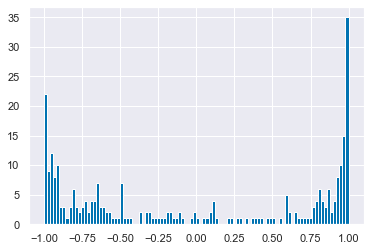

In [33]:
X_test_reconst.corrwith(pd.Series(encoded_imgs.reshape(X_test.shape[0]),index=X_test.index)).sort_values().hist(bins=100)

In [34]:
X_test_reconst.corrwith(pd.Series(encoded_imgs.reshape(X_test.shape[0]),index=X_test.index)).sort_values().head(50)

generalElectionVote_Labour                                                                                      -0.999850
p_work_stat_Working full time (30 or more hours per week)                                                       -0.999616
workingStatusPartner_Working full time (30 or more hours per week)                                              -0.999603
gor_East of England                                                                                             -0.999349
p_marital_Living with a partner but neither married nor in a civil partnership                                  -0.999204
workingStatus_Working full time (30 or more hours per week)                                                     -0.999054
p_housing_Rent from a private landlord                                                                          -0.998932
p_past_vote_2019_Labour                                                                                         -0.998871
jobForAll__Strongly agre

In [35]:
X_test_reconst.corrwith(pd.Series(encoded_imgs.reshape(X_test.shape[0]),index=X_test.index)).sort_values().tail(50)

handleCorona__Very well                                                                  0.962451
p_welsh_const_vote_2016_Conservative                                                     0.962624
resourceAccess1_1_Yes                                                                    0.962660
partnerEducation_CSE grade 1, GCE O level, GCSE, School Certificate                      0.964539
EUIntegrationSelf__Protect our independence                                              0.965646
coronaMeasures2_1_Yes                                                                    0.966235
p_past_vote_2010_Conservative                                                            0.967118
govtHandlelockdown__Very well                                                            0.967844
govtHandlePPE__Very well                                                                 0.970664
likeJohnson__Strongly like                                                               0.970974
sector_Self-employed

In [212]:
X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).sort_values().tail(50)


p_past_vote_2017_Labour                                                                                                                   0.842220
bestOnMII_Labour                                                                                                                          0.843398
highRiskLetter_none_Yes                                                                                                                   0.845901
p_job_sector_Private sector profit-seeking (e.g. public limited company, partnership)                                                     0.846124
sector_Other public sector employer Incl eg: - Central govt/ Civil Service/ Govt Agency - Local authority/ Local Educ Auth/sch            0.846246
ptvLab__Very likely                                                                                                                       0.847280
workingStatusPartner_Working full time (30 or more hours per week)                                                    

In [202]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       (None, 289)               0         
_________________________________________________________________
dense_134 (Dense)            (None, 100)               29000     
_________________________________________________________________
dense_135 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_136 (Dense)            (None, 100)               3300      
_________________________________________________________________
dense_137 (Dense)            (None, 289)               29189     
Total params: 64,721
Trainable params: 64,721
Non-trainable params: 0
_________________________________________________________________


In [145]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        (None, 742)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 100)               74300     
_________________________________________________________________
dense_80 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_81 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_82 (Dense)             (None, 742)               74942     
Total params: 155,774
Trainable params: 155,774
Non-trainable params: 0
_________________________________________________________________


In [112]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 742)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               74300     
_________________________________________________________________
dense_48 (Dense)             (None, 32)                3232      
Total params: 77,532
Trainable params: 77,532
Non-trainable params: 0
_________________________________________________________________


In [113]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)               3300      
Total params: 3,300
Trainable params: 3,300
Non-trainable params: 0
_________________________________________________________________


In [116]:
autoencoder.layers[-1]

In [118]:
encoded_input

<tf.Tensor 'input_47:0' shape=(?, 32) dtype=float32>

In [174]:
# # Model(input_img, autoencoder.layers[])
# Model(encoded_input, autoencoder.layers[-1](encoded_input))

In [173]:
# # create a placeholder for an encoded (32-dimensional) input
# encoded_input = Input(shape=(encoding_dim,))
# # retrieve the last layer of the autoencoder model
# ## changed to -2 after adding hidden layer!
# decoder_layer = autoencoder.layers[-1]
# # create the decoder model
# decoder = Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
# encoding_dim = 32
# Epoch 2/50
#  - 2s - loss: 5935.9533 - acc: 0.3057 - val_loss: 5822.0374 - val_acc: 0.5679
# Epoch 50/50
#  - 2s - loss: 5680.6994 - acc: 0.8580 - val_loss: 5683.9633 - val_acc: 0.8727

# encoding_dim = 16
# Epoch 2/50
#  - 2s - loss: 5978.8631 - acc: 0.8325 - val_loss: 5866.3392 - val_acc: 0.8639
# Epoch 50/50
#  - 3s - loss: 5694.4223 - acc: 0.8617 - val_loss: 5697.4094 - val_acc: 0.8703

# encoding_dim = 8
# Epoch 2/50
#  - 2s - loss: 5970.0431 - acc: 0.8586 - val_loss: 5835.3781 - val_acc: 0.8639
# Epoch 50/50
#  - 2s - loss: 5715.6143 - acc: 0.8595 - val_loss: 5718.3449 - val_acc: 0.8642

# encoding_dim = 1
# Epoch 2/50
#  - 2s - loss: 6096.5372 - acc: 0.0000e+00 - val_loss: 6056.0097 - val_acc: 0.0000e+00
# Epoch 38/50
#  - 2s - loss: 5753.8536 - acc: 0.0416 - val_loss: 5756.7104 - val_acc: 0.0403

# encoding_dim = 2
# Epoch 2/50
#  - 2s - loss: 6086.2950 - acc: 0.0000e+00 - val_loss: 6052.0046 - val_acc: 0.0000e+00
# Epoch 41/50
#  - 2s - loss: 5729.3915 - acc: 0.8586 - val_loss: 5731.9737 - val_acc: 0.8639

## WTF!
# encoding_dim = 3
# Epoch 2/50
#  - 2s - loss: 6062.5483 - acc: 0.0074 - val_loss: 6017.2380 - val_acc: 0.0075
# Epoch 38/50
#  - 3s - loss: 5735.6843 - acc: 0.0442 - val_loss: 5738.1730 - val_acc: 0.0402

# encoding_dim = 4
# Epoch 2/50
#  - 2s - loss: 6040.1189 - acc: 4.7432e-05 - val_loss: 5968.3275 - val_acc: 0.0000e+00
# Epoch 50/50
#  - 2s - loss: 5723.7691 - acc: 0.8586 - val_loss: 5726.4317 - val_acc: 0.8639                   

In [ ]:
# encoding_dim = 4
# hidden_size = 0

# Epoch 2/50
#  - 1s - loss: 2.0178 - acc: 0.8586 - val_loss: 1.8578 - val_acc: 0.8639
# Epoch 50/50
#  - 2s - loss: 0.3624 - acc: 0.9903 - val_loss: 0.3628 - val_acc: 0.9922

In [119]:
# encoded_imgs = encoder.predict(X_test.values)
# decoded_imgs = decoder.predict(encoded_imgs)

# # save latent space features 32-d vector
# pickle.dump(encoded_imgs, open(features_path, 'wb'))
# pickle.dump(y_test, open(labels_path, 'wb'))


In [121]:
encoded_imgs.shape

(10385, 32)

In [ ]:
# %%time

# hasattr(tf_gradients_impl, "_IsBackpropagatable")
background = X.loc[X.index[np.random.choice(X.shape[0], 200, replace=False)]]

# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
e = shap.DeepExplainer(model, background.values)
shap_values = e.shap_values(background.values)

In [105]:
decoder_layer.input_shape

(None, 100)

In [13]:
encoded_imgs.shape

(10385, 32)

In [125]:
encoded_imgs.shape

(10385, 32)

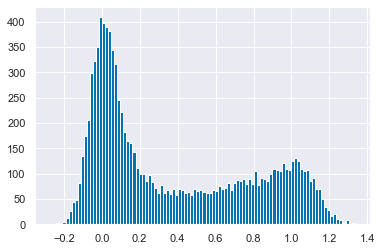

In [195]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

In [196]:
X_test_reconst["p_past_vote_2019_Conservative"].corr(X_test["p_past_vote_2019_Conservative"])

0.8510384676776054

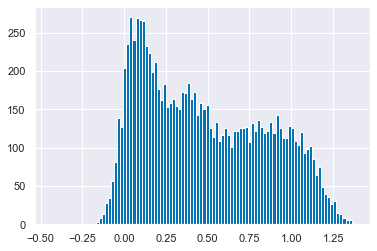

In [176]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

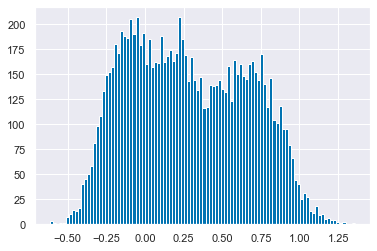

In [83]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

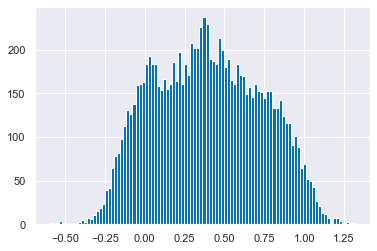

In [96]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

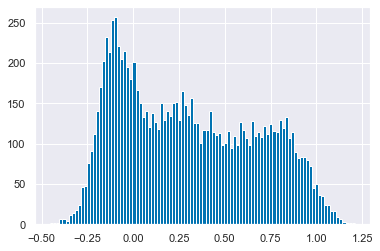

In [101]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

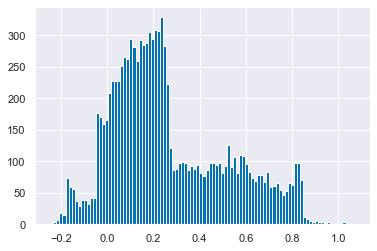

In [168]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

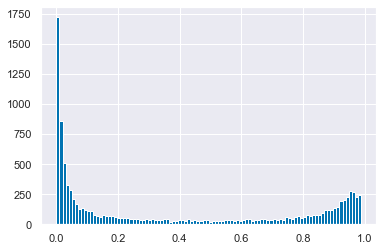

In [171]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

In [109]:
decoded_imgs.shape

(10385, 100)

0.7519656733240291

In [98]:
X_test["p_past_vote_2019_Conservative"].value_counts()

0    6541
1    3844
Name: p_past_vote_2019_Conservative, dtype: int64

In [99]:
X_test_reconst["p_past_vote_2019_Conservative"].corr(X_test["p_past_vote_2019_Conservative"])

0.69317105471296

In [68]:
X_test["p_past_vote_2019_Conservative"]

id
66014     1
78512     1
102320    0
44782     0
100932    0
         ..
51434     1
101213    0
14449     1
7930      0
59978     0
Name: p_past_vote_2019_Conservative, Length: 10385, dtype: uint8

In [69]:
X_test_reconst["p_past_vote_2019_Conservative"]

id
66014     0.343306
78512     0.952774
102320    0.006326
44782     0.036370
100932    0.046496
            ...   
51434     0.992141
101213    0.002963
14449     0.990144
7930      0.036385
59978     0.038661
Name: p_past_vote_2019_Conservative, Length: 10385, dtype: float32

In [87]:
X_test["p_past_vote_2019_Conservative"].mean()

0.3701492537313433

0.7247054790225834

In [90]:
(X_test_reconst-X_test).applymap(lambda x: x**2).mean().sort_values()

fatherVote_Plaid Cymru                                                     0.000452
partyIdSqueeze_Plaid Cymru                                                 0.000723
motherVote_Plaid Cymru                                                     0.000847
fatherVote_Scottish National Party (SNP)                                   0.001016
ns_sec_L12.5 Semi-routine agricultural occupations                         0.001262
                                                                             ...   
worryCoronaHealth__Extremely Worried                                       4.011829
cvEconSelf__Save the economy even if it increases infections               4.099110
p_gross_household__£150,000 and over                                       4.122387
cvFreedomSelf__Protect personal freedom even if it increases infections    4.274847
worryCoronaPub__Extremely Worried                                          4.363718
Length: 742, dtype: float64

In [37]:
X_test_reconst["p_past_vote_2019_Conservative"].sum(),X_test["p_past_vote_2019_Conservative"].sum()

(4005.9648, 3844)

In [57]:
X_test_reconst["p_past_vote_2019_Conservative"].sum(),X_test["p_past_vote_2019_Conservative"].sum()

(54.293293, 3844)

In [53]:
encoded_imgs

array([[28.89605 , 30.912666, 36.709103,  0.      ],
       [32.253   , 23.422077, 34.824047,  0.      ],
       [25.277166, 40.572582, 29.26418 ,  0.      ],
       ...,
       [30.91752 , 23.406105, 40.072803,  0.      ],
       [25.83636 , 32.851925, 33.76849 ,  0.      ],
       [28.247217, 35.77055 , 31.923008,  0.      ]], dtype=float32)

In [72]:
X.max()

turnoutUKGeneral__Very likely that I will vote     4.0
partyIdStrength__Not very strong                   2.0
polAttention__Pay a great deal of attention       10.0
pidWeThey__Strongly agree                          3.0
pidInterestedOthers__Strongly agree                3.0
                                                  ... 
responsibleEconC_2_Yes                             1.0
responsibleEconC_1_Yes                             1.0
coronaMeasures_2_Yes                               1.0
coronaMeasures_1_Yes                               1.0
coronaMeasures_4_Yes                               1.0
Length: 742, dtype: float32

In [4]:
prep = BES_Panel.select_dtypes('category')
prep = prep.copy()#[temp.columns[0:100]].copy()
prep.dropna(axis=1,inplace=True)

y = BES_Panel['p_eurefvote']

In [43]:
# search(BES_Panel,"eurefvote")

In [44]:

# y = to_categorical(y)

In [5]:
# prepare target
# def prepare_targets(y_train, y_test):
#     le = LabelEncoder()
#     le.fit(y_train)
#     y_train_enc = le.transform(y_train)
#     y_test_enc = le.transform(y_test)
#     return y_train_enc, y_test_enc


enc = OrdinalEncoder()

X = enc.fit_transform(prep)
X = pd.DataFrame(X,columns = prep.columns,index = prep.index)

In [46]:
# X = prep

In [252]:
# no_hidden_layers=2
# x = pow(X.shape[1]/encoding_dim,1/ (no_hidden_layers+1) )
# [encoding_dim]+[int(encoding_dim*pow(x,y)) for y in range(1,no_hidden_layers+1)]

In [7]:
# all layers
def get_kernel_regularizer(orthogonality_constraint,dimension,axis,weight=10e-7,weightage=1.0):
    if orthogonality_constraint:
        return WeightsOrthogonalityConstraint(dimension, weightage=weightage, axis=axis)
    else:
        return regularizers.l2(weight)

# just encoding layer (all of them or just final? Just final surely?)
def get_activity_regularizer(uncorrelated_features,encoding_dim, weightage = 1.):
    if uncorrelated_features:
        return UncorrelatedFeaturesConstraint(encoding_dim, weightage = 1.)
    else:
        return None

# all layers: kernel_constraint=get_kernel_constraint(unit_norm, axis)
def get_kernel_constraint(unit_norm, axis):
    if unit_norm:
        return UnitNorm(axis=axis)
    else:
        return None    

def run_autoencoder(encoding_dim=32,hidden_size=100,verbose=2,
                    loss='mean_squared_error',metrics=['accuracy','mse'],optimizer='adam',
                    penultimate_act = 'relu',ultimate_act = 'linear',max_epochs=100,
                    no_hidden_layers=1,
                    tied_layers = False, orthogonality_constraint = False,uncorrelated_features=False,unit_norm=False,
                    regularizer_weight=10e-7):

    # get rough intermediate sizes for hidden layers
    x = pow(X.shape[1]/encoding_dim,1/ (no_hidden_layers+1) )
    if no_hidden_layers!=1:
        hidden_layer_size = [int(encoding_dim*pow(x,y)) for y in range(1,no_hidden_layers+1)]
    else:
        hidden_layer_size = [hidden_size]
    
     
    
    # Single fully-connected neural layer as encoder and decoder
    use_regularizer = True
#     my_regularizer = None
#     my_epochs = 50
    features_path = 'simple_autoe_features.pickle'
    labels_path = 'simple_autoe_labels.pickle'

    early_stopping_monitor = EarlyStopping(patience=3)

    if use_regularizer:
        # add a sparsity constraint on the encoded representations
        # note use of 10e-5 leads to blurred results
    #     my_regularizer = regularizers.l1(10e-8)
        # and a larger number of epochs as the added regularization the model
        # is less likely to overfit and can be trained longer
#         my_epochs = 100
        features_path = 'sparse_autoe_features.pickle'
        labels_path = 'sparse_autoe_labels.pickle'

    # this is the size of our encoded representations
    # encoding_dim = encoding_dim   # 32 floats -> compression factor 24.5, assuming the input is 784 floats
    # hidden_size = hidden_size

# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias=True,
#                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)) 
# decoder = Dense(input_dim, activation="linear", use_bias = True,
#                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=1))    


    

    # this is our input placeholder; 784 = 28 x 28
    # input_img = Input(shape=(784, ))

    input_img = Input(shape=(X.shape[1], ))

    encoder_list = []
    
    # "encoded" is the encoded representation of the inputs
    hidden_encoder = input_img
    for hidden_layer_number in range(no_hidden_layers-1,-1,-1):       
        
        d = Dense(hidden_layer_size[hidden_layer_number], activation = penultimate_act,
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                                    hidden_layer_size[hidden_layer_number],
                                                                    axis=0, weight=regularizer_weight),
                          kernel_constraint=get_kernel_constraint(unit_norm, axis=0)
                 )
        
        hidden_encoder = d(hidden_encoder)
        encoder_list.append(d)
    
    d = Dense(encoding_dim, activation=penultimate_act,
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                encoding_dim,
                                                axis=0, weight=regularizer_weight),
                          activity_regularizer= get_activity_regularizer(uncorrelated_features,encoding_dim, weightage = 1.),
                          kernel_constraint=get_kernel_constraint(unit_norm, axis=0)
             )
    
    encoded = d(hidden_encoder)
    encoder_list.append(d)
    # encoded = Dense(encoding_dim, activation='relu', activity_regularizer=my_regularizer)(input_img)


    # "decoded" is the lossy reconstruction of the input
    # decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
    
    
#     decoder = DenseTied(input_dim, activation="linear", tied_to=encoder, use_bias = True)   
    
    hidden_decoder = encoded
    for hidden_layer_number in range(0,no_hidden_layers):
        if tied_layers:
            hidden_decoder = DenseTied(hidden_layer_size[hidden_layer_number], activation = penultimate_act,
                                      tied_to=encoder_list[no_hidden_layers-hidden_layer_number],
                                      kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                                    ([encoding_dim]+hidden_layer_size)[hidden_layer_number],
                                                                    axis=1, weight=regularizer_weight),  
                                      kernel_constraint=get_kernel_constraint(unit_norm, axis=1),
                                      )(hidden_decoder)
            
        else:
            hidden_decoder = Dense(hidden_layer_size[hidden_layer_number], activation = penultimate_act,
                                      kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                ([encoding_dim]+hidden_layer_size)[hidden_layer_number],
                                                 axis=1, weight=regularizer_weight),   
                                      kernel_constraint=get_kernel_constraint(unit_norm, axis=1)
                                      )(hidden_decoder)
            
    if tied_layers:
        decoded = DenseTied(X.shape[1], activation=ultimate_act,
                          tied_to=encoder_list[0],
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                    ([encoding_dim]+hidden_layer_size)[no_hidden_layers],
                                     axis=1, weight=regularizer_weight),   
                                     kernel_constraint=get_kernel_constraint(unit_norm, axis=1)
                           )(hidden_decoder)

    else:            
        decoded = Dense(X.shape[1], activation=ultimate_act,
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                    ([encoding_dim]+hidden_layer_size)[no_hidden_layers],
                                     axis=1, weight=regularizer_weight),  
                          kernel_constraint=get_kernel_constraint(unit_norm, axis=1)
                       )(hidden_decoder)
    # decoded = Dense(X.shape[1], activation='linear')(encoded)
    # decoded = Dense(X.shape[1], activation='softmax')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # Separate Encoder model

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # Separate Decoder model

    # create a placeholder for an encoded (32-dimensional) input
#     encoded_input = Input(shape=(encoding_dim,))
    # hidden_layer_input = Input(shape=(hidden_size,))
    # retrieve the last layer of the autoencoder model
    ## changed to -2 after adding hidden layer!
    # decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    # decoder = Model(encoded_input, decoder_layer(hidden_layer_input))
    encoded_input_layer = InputLayer(input_shape=(encoding_dim,))
    # decoder = Model(encoded_input, decoder_layer(encoded_input))

    decoder = extract_layers(autoencoder, -1-no_hidden_layers, -1, encoded_input_layer)

    # Train to reconstruct MNIST digits

    # configure model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.compile( optimizer = optimizer,
    #                loss = 'categorical_crossentropy',
    #                loss = 'categorical_crossentropy',
                   loss = loss,     
                   metrics=metrics)


    # # prepare input data
    # (x_train, _), (x_test, y_test) = mnist.load_data()

    # # normalize all values between 0 and 1 and flatten the 28x28 images into vectors of size 784
    # x_train = x_train.astype('float32') / 255.
    # x_test = x_test.astype('float32') / 255.
    # x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    # x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    # print(x_train.shape)
    # print(x_test.shape)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

    # Train autoencoder for 50 epochs

    if isinstance(X_test, pd.DataFrame):
        X_test_values = X_test.values
        X_train_values = X_train.values
    else:
        X_test_values = X_test
        X_train_values = X_train
    
    autoencoder.fit(X_train_values, X_train_values, epochs=max_epochs, batch_size=512,
                    shuffle=True, validation_data=(X_test_values, X_test_values),
                    verbose=verbose, callbacks=[early_stopping_monitor])

    # after 50/100 epochs the autoencoder seems to reach a stable train/test lost value

    # Visualize the reconstructed encoded representations

    # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(X_test_values)
    decoded_imgs = decoder.predict(encoded_imgs)

    # save latent space features 32-d vector
    pickle.dump(encoded_imgs, open(features_path, 'wb'))
    pickle.dump(y_test, open(labels_path, 'wb'))

    # n = 10  # how many digits we will display
    # plt.figure(figsize=(10, 2), dpi=100)
    # for i in range(n):
    #     # display original
    #     ax = plt.subplot(2, n, i + 1)
    #     plt.imshow(x_test[i].reshape(28, 28))
    #     plt.gray()
    #     ax.set_axis_off()

    #     # display reconstruction
    #     ax = plt.subplot(2, n, i + n + 1)
    #     plt.imshow(decoded_imgs[i].reshape(28, 28))
    #     plt.gray()
    #     ax.set_axis_off()kernel_constrain

    # plt.show()
    
    return decoded_imgs,X_test,encoded_imgs,autoencoder,encoder,decoder

In [ ]:
## turn all columns into something like cateogory


## dummy all columns, special option for nans
# dummy_na


## could do sparse output

In [ ]:
prep.shape,BES_Panel.shape

In [235]:
prep2 = BES_Panel.copy()
prep2["jobzone"] = prep2["jobzone"].astype('category')
prep2["country"] = prep2["country"].replace({1.0:"England",2.0:"Scotland",3.0:"Wales"}).astype('category')

In [239]:
prep2 = pd.get_dummies(prep2.select_dtypes('category'), dummy_na=True)
prep2_var = prep2.var()
prep2 = prep2[prep2_var[prep2_var>.005].index]

In [331]:
prep3 = BES_Panel.copy()
prep3 = prep3[search(BES_Panel,"p_").index]
prep3 = pd.get_dummies(prep3.select_dtypes('category'), dummy_na=True)

In [253]:
# prep2_var.shape[prep2_var<.01]

# 2202/2540 /5105


In [254]:
# BES_Panel.apply(lambda x: x.dtype.name).value_counts()

In [255]:
# BES_Panel.select_dtypes('number')

In [9]:
prep = BES_Panel.select_dtypes('category')
prep = prep.copy()#[temp.columns[0:100]].copy()
prep.dropna(axis=1,inplace=True)

y = BES_Panel['p_eurefvote']

In [10]:
# prepare target
# def prepare_targets(y_train, y_test):
#     le = LabelEncoder()
#     le.fit(y_train)
#     y_train_enc = le.transform(y_train)
#     y_test_enc = le.transform(y_test)
#     return y_train_enc, y_test_enc
enc = OneHotEncoder(sparse=False)

X = enc.fit_transform(prep)
# X = pd.DataFrame(X,columns = prep.columns,index = prep.index)

In [13]:
# low_var_columns = X.columns[X.var()<.05]
not_low_var_columns = pd.DataFrame(X).columns[pd.DataFrame(X).var()>.005]
X = X[:,not_low_var_columns]
# X.drop(low_var_columns,axis=1,inplace=True)
X.shape

(31468, 1214)

In [332]:
X = prep3

In [9]:
# hidden_layer_size

In [10]:
# X.max()

In [11]:
# low_var_columns
# X
# if tied_layers:
#     print(1)

In [333]:
# not_low_var_columns
import warnings
warnings.filterwarnings('ignore')

In [40]:
losses = pd.DataFrame(columns = ['encoding_dim','hidden_size','num_epochs',
                                 'val_loss', 'val_acc', 'val_mean_squared_error', 'val_binary_accuracy',
                                 'val_binary_crossentropy', 'val_kullback_leibler_divergence', 'loss', 'acc',
                                 'mean_squared_error', 'binary_accuracy', 'binary_crossentropy', 'kullback_leibler_divergence',
                                 'mean_correlation'])
count = 0

In [14]:
losses = pd.read_csv("losses.csv")
losses.drop("Unnamed: 0",axis=1,inplace=True)
count = losses.index[-1]+1

In [99]:
## add noise, store old X in X_old

X_old = X.copy()

temp = pd.DataFrame(X).astype(bool)

rng = np.random.default_rng()
e = pd.DataFrame(rng.integers(0, 2, size=temp.shape) ).astype(bool)
e = np.random.uniform(0.0, 1.0, size=temp.shape )>.999

temp2 = np.where(e,(~temp).astype('int'),temp.astype('int'))

temp.apply(lambda x: pd.DataFrame(temp2)[x.name].corr( temp[x.name] ) )

X = temp2

In [158]:
# e.sum()/(e.shape[0]*e.shape[1])


In [171]:

# # tied_layers,orthogonality_constraint,uncorrelated_features,unit_norm
# # str([1,0,0,0])


# # (tied_layers,orthogonality_constraint,uncorrelated_features,unit_norm) = (bool(x) for x in combo)   
# tied_layers=False
# orthogonality_constraint=False
# uncorrelated_features=False
# unit_norm=False
# tied_layers

# # del tied_layers,orthogonality_constraint,uncorrelated_features,unit_norm
# # tied_layers

# dir( tf.keras.losses )

In [334]:
description="regularizer_weight=10e-7 argument fixed"

hidden_size=100

tied_layers=True
orthogonality_constraint=False
uncorrelated_features=True
unit_norm=False

regularizer_weight=10e-6
# test thjis again
# try l1 regularizer?
no_hidden_layers=2
shuffle=True
batch_size=512
lr = .003

bit_flip = .999
loss = 'binary_crossentropy'

for encoding_dim in [13]:
    
    for regularizer_weight in [10e-6]: #,10e-7,10e-8
        optimizer = tf.keras.optimizers.Adamax(lr=lr)     
        # , beta_1=0.9, beta_2=0.999, epsilon=1e-07
        for no_hidden_layers in [1]:
        #[ [1,0,1,0],[1,1,1,0],[1,0,1,1],[1,1,1,1], ]:
        
#             (tied_layers,orthogonality_constraint,uncorrelated_features,unit_norm) = (bool(x) for x in combo)   
#         for regularizer_weight in [10e-8]:

#             description = str("learning_rate="+str(lr))
            description = "full dataset with hidden layers="+str(no_hidden_layers)
            start_time = time.time()
            print("encoding_dim = "+str(encoding_dim),"hidden_size = "+str(hidden_size),"no_hidden_layers = ",str(no_hidden_layers))
            decoded_imgs,X_test,encoded_imgs,autoencoder,encoder,decoder = run_autoencoder(encoding_dim=encoding_dim,
                                                                                           hidden_size=hidden_size,
                                                                                           verbose=2,
                                                                                           loss=loss,
                                                                                           ultimate_act='sigmoid',
                                                                                           metrics=['accuracy',
                                                                                                    'mse',
                                                                                                    'binary_accuracy',
                                                                                                    'binary_crossentropy',
                                                                                                    'kullback_leibler_divergence',
                                                                                                    ],
                                                                                          max_epochs=200,
                                                                                          no_hidden_layers=no_hidden_layers,
                                                                                          tied_layers=tied_layers,
                                                                                          orthogonality_constraint=orthogonality_constraint,
                                                                                          uncorrelated_features=uncorrelated_features,
                                                                                          unit_norm=unit_norm,
                                                                                          regularizer_weight=regularizer_weight,
                                                                                          optimizer=optimizer,
                                                                                          )

            X_test = pd.DataFrame(X_test)

            X_test_reconst = pd.DataFrame(decoded_imgs)
            X_test_reconst.columns = X_test.columns
            X_test_reconst.index = X_test.index
            mean_correlation  = X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean()        

    #         X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
        #     X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)
    #         print("p_past_vote_2019_Conservative correlation =")
    #         print(X_test_reconst["p_past_vote_2019_Conservative"].corr(X_test["p_past_vote_2019_Conservative"]))
            print("mean correlation =")
            print(mean_correlation)
            elapsed_time = time.time() - start_time
            print("elapsed_time = ",elapsed_time)
            losses.loc[count] = [encoding_dim,hidden_size]+[autoencoder.history.epoch[-1]]+[x[-1] for x in autoencoder.history.history.values()]+[mean_correlation]+[no_hidden_layers]+[elapsed_time]+[description]
            count=count+1        

encoding_dim = 13 hidden_size = 100 no_hidden_layers =  1
Train on 21083 samples, validate on 10385 samples
Epoch 1/200
 - 8s - loss: 0.3407 - acc: 0.8705 - mean_squared_error: 0.1067 - binary_accuracy: 0.8705 - binary_crossentropy: 0.3386 - kullback_leibler_divergence: 35.1494 - val_loss: 0.2060 - val_acc: 0.9213 - val_mean_squared_error: 0.0596 - val_binary_accuracy: 0.9213 - val_binary_crossentropy: 0.2036 - val_kullback_leibler_divergence: 48.2577
Epoch 2/200
 - 2s - loss: 0.1921 - acc: 0.9280 - mean_squared_error: 0.0549 - binary_accuracy: 0.9280 - binary_crossentropy: 0.1896 - kullback_leibler_divergence: 42.7737 - val_loss: 0.1780 - val_acc: 0.9349 - val_mean_squared_error: 0.0502 - val_binary_accuracy: 0.9349 - val_binary_crossentropy: 0.1755 - val_kullback_leibler_divergence: 39.5132
Epoch 3/200
 - 2s - loss: 0.1704 - acc: 0.9379 - mean_squared_error: 0.0479 - binary_accuracy: 0.9379 - binary_crossentropy: 0.1678 - kullback_leibler_divergence: 38.0854 - val_loss: 0.1642 - val_

Epoch 25/200
 - 1s - loss: 0.1054 - acc: 0.9633 - mean_squared_error: 0.0285 - binary_accuracy: 0.9633 - binary_crossentropy: 0.1021 - kullback_leibler_divergence: 23.2401 - val_loss: 0.1063 - val_acc: 0.9632 - val_mean_squared_error: 0.0287 - val_binary_accuracy: 0.9632 - val_binary_crossentropy: 0.1030 - val_kullback_leibler_divergence: 23.6641
Epoch 26/200
 - 1s - loss: 0.1048 - acc: 0.9636 - mean_squared_error: 0.0283 - binary_accuracy: 0.9636 - binary_crossentropy: 0.1014 - kullback_leibler_divergence: 23.0980 - val_loss: 0.1057 - val_acc: 0.9635 - val_mean_squared_error: 0.0285 - val_binary_accuracy: 0.9635 - val_binary_crossentropy: 0.1023 - val_kullback_leibler_divergence: 23.4951
Epoch 27/200
 - 1s - loss: 0.1042 - acc: 0.9638 - mean_squared_error: 0.0281 - binary_accuracy: 0.9638 - binary_crossentropy: 0.1008 - kullback_leibler_divergence: 22.9583 - val_loss: 0.1052 - val_acc: 0.9636 - val_mean_squared_error: 0.0284 - val_binary_accuracy: 0.9636 - val_binary_crossentropy: 0.1

Epoch 49/200
 - 1s - loss: 0.0955 - acc: 0.9672 - mean_squared_error: 0.0255 - binary_accuracy: 0.9672 - binary_crossentropy: 0.0916 - kullback_leibler_divergence: 20.9209 - val_loss: 0.0970 - val_acc: 0.9668 - val_mean_squared_error: 0.0259 - val_binary_accuracy: 0.9668 - val_binary_crossentropy: 0.0931 - val_kullback_leibler_divergence: 21.3064
Epoch 50/200
 - 1s - loss: 0.0952 - acc: 0.9673 - mean_squared_error: 0.0254 - binary_accuracy: 0.9673 - binary_crossentropy: 0.0913 - kullback_leibler_divergence: 20.8623 - val_loss: 0.0968 - val_acc: 0.9668 - val_mean_squared_error: 0.0258 - val_binary_accuracy: 0.9668 - val_binary_crossentropy: 0.0929 - val_kullback_leibler_divergence: 21.5360
Epoch 51/200
 - 1s - loss: 0.0950 - acc: 0.9674 - mean_squared_error: 0.0254 - binary_accuracy: 0.9674 - binary_crossentropy: 0.0910 - kullback_leibler_divergence: 20.7907 - val_loss: 0.0966 - val_acc: 0.9670 - val_mean_squared_error: 0.0257 - val_binary_accuracy: 0.9670 - val_binary_crossentropy: 0.0

Epoch 73/200
 - 1s - loss: 0.0902 - acc: 0.9693 - mean_squared_error: 0.0239 - binary_accuracy: 0.9693 - binary_crossentropy: 0.0859 - kullback_leibler_divergence: 19.6971 - val_loss: 0.0922 - val_acc: 0.9687 - val_mean_squared_error: 0.0244 - val_binary_accuracy: 0.9687 - val_binary_crossentropy: 0.0879 - val_kullback_leibler_divergence: 19.9874
Epoch 74/200
 - 1s - loss: 0.0901 - acc: 0.9694 - mean_squared_error: 0.0238 - binary_accuracy: 0.9694 - binary_crossentropy: 0.0858 - kullback_leibler_divergence: 19.6626 - val_loss: 0.0919 - val_acc: 0.9689 - val_mean_squared_error: 0.0243 - val_binary_accuracy: 0.9689 - val_binary_crossentropy: 0.0876 - val_kullback_leibler_divergence: 19.9466
Epoch 75/200
 - 1s - loss: 0.0899 - acc: 0.9695 - mean_squared_error: 0.0238 - binary_accuracy: 0.9695 - binary_crossentropy: 0.0856 - kullback_leibler_divergence: 19.6165 - val_loss: 0.0919 - val_acc: 0.9689 - val_mean_squared_error: 0.0243 - val_binary_accuracy: 0.9689 - val_binary_crossentropy: 0.0

Epoch 97/200
 - 1s - loss: 0.0871 - acc: 0.9706 - mean_squared_error: 0.0229 - binary_accuracy: 0.9706 - binary_crossentropy: 0.0825 - kullback_leibler_divergence: 18.9331 - val_loss: 0.0892 - val_acc: 0.9699 - val_mean_squared_error: 0.0234 - val_binary_accuracy: 0.9699 - val_binary_crossentropy: 0.0847 - val_kullback_leibler_divergence: 19.6663
Epoch 98/200
 - 1s - loss: 0.0870 - acc: 0.9706 - mean_squared_error: 0.0229 - binary_accuracy: 0.9706 - binary_crossentropy: 0.0825 - kullback_leibler_divergence: 18.9381 - val_loss: 0.0891 - val_acc: 0.9699 - val_mean_squared_error: 0.0234 - val_binary_accuracy: 0.9699 - val_binary_crossentropy: 0.0846 - val_kullback_leibler_divergence: 19.4217
Epoch 99/200
 - 1s - loss: 0.0868 - acc: 0.9707 - mean_squared_error: 0.0228 - binary_accuracy: 0.9707 - binary_crossentropy: 0.0823 - kullback_leibler_divergence: 18.8947 - val_loss: 0.0889 - val_acc: 0.9701 - val_mean_squared_error: 0.0233 - val_binary_accuracy: 0.9701 - val_binary_crossentropy: 0.0

Epoch 121/200
 - 1s - loss: 0.0845 - acc: 0.9716 - mean_squared_error: 0.0221 - binary_accuracy: 0.9716 - binary_crossentropy: 0.0798 - kullback_leibler_divergence: 18.3233 - val_loss: 0.0866 - val_acc: 0.9710 - val_mean_squared_error: 0.0226 - val_binary_accuracy: 0.9710 - val_binary_crossentropy: 0.0818 - val_kullback_leibler_divergence: 18.9620
Epoch 122/200
 - 1s - loss: 0.0844 - acc: 0.9717 - mean_squared_error: 0.0221 - binary_accuracy: 0.9717 - binary_crossentropy: 0.0796 - kullback_leibler_divergence: 18.3117 - val_loss: 0.0866 - val_acc: 0.9710 - val_mean_squared_error: 0.0226 - val_binary_accuracy: 0.9710 - val_binary_crossentropy: 0.0818 - val_kullback_leibler_divergence: 19.0870
Epoch 123/200
 - 1s - loss: 0.0843 - acc: 0.9717 - mean_squared_error: 0.0221 - binary_accuracy: 0.9717 - binary_crossentropy: 0.0795 - kullback_leibler_divergence: 18.2999 - val_loss: 0.0864 - val_acc: 0.9710 - val_mean_squared_error: 0.0226 - val_binary_accuracy: 0.9710 - val_binary_crossentropy: 

Epoch 145/200
 - 1s - loss: 0.0824 - acc: 0.9725 - mean_squared_error: 0.0215 - binary_accuracy: 0.9725 - binary_crossentropy: 0.0773 - kullback_leibler_divergence: 17.7987 - val_loss: 0.0848 - val_acc: 0.9717 - val_mean_squared_error: 0.0221 - val_binary_accuracy: 0.9717 - val_binary_crossentropy: 0.0797 - val_kullback_leibler_divergence: 18.6606
Epoch 146/200
 - 1s - loss: 0.0823 - acc: 0.9725 - mean_squared_error: 0.0214 - binary_accuracy: 0.9725 - binary_crossentropy: 0.0773 - kullback_leibler_divergence: 17.7886 - val_loss: 0.0846 - val_acc: 0.9717 - val_mean_squared_error: 0.0221 - val_binary_accuracy: 0.9717 - val_binary_crossentropy: 0.0796 - val_kullback_leibler_divergence: 18.3101
Epoch 147/200
 - 1s - loss: 0.0823 - acc: 0.9725 - mean_squared_error: 0.0214 - binary_accuracy: 0.9725 - binary_crossentropy: 0.0772 - kullback_leibler_divergence: 17.7750 - val_loss: 0.0846 - val_acc: 0.9717 - val_mean_squared_error: 0.0220 - val_binary_accuracy: 0.9717 - val_binary_crossentropy: 

In [296]:
# count=count+1

In [335]:
# X_test_reconst.columns = X_test.columns
# X_test_reconst.index = X_test.index
# mean_correlation  = X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean()
# # count=count-1 
# losses.loc[count] = [encoding_dim,hidden_size]+[autoencoder.history.epoch[-1]]+[x[-1] for x in autoencoder.history.history.values()]+[mean_correlation]+[no_hidden_layers]+[elapsed_time]+[description]


In [336]:
corr_dist = X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) )

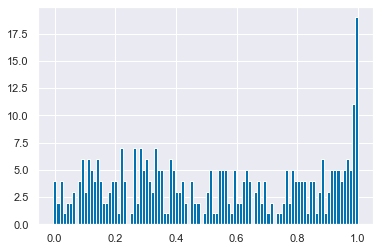

In [337]:
corr_dist.hist(bins=100)

In [338]:
corr_dist[corr_dist<.05].head(50)

p_country_birth_North America                                0.021815
p_country_birth_South America                                0.029379
p_country_birth_Middle East                                  0.002498
p_ethnicity_White and Black African                          0.019033
p_ethnicity_Any other black background                       0.015693
p_marital_nan                                                0.005080
p_religion_Yes - Baptist                                     0.040773
p_religion_Yes - United Reformed Church                      0.047432
p_religion_Yes - Free Presbyterian                          -0.003757
p_religion_Yes - Brethren                                    0.007117
p_socgrade_Unknown                                           0.003594
p_past_vote_2015_British National Party (BNP)                0.043844
p_past_vote_2019_United Kingdom Independence Party (UKIP)    0.019192
p_turnout_scot_ref_No, I was not eligible to vote            0.024598
dtype: float64

In [340]:
corr_dist[corr_dist>.95].head(50)

p_education_No formal qualifications                                 0.997683
p_education_City & Guilds certificate                                0.970505
p_education_CSE grade 1, GCE O level, GCSE, School Certificate       0.994114
p_education_GCE A level or Higher Certificate                        0.995719
p_education_University or CNAA first degree (e.g. BA, B.Sc, B.Ed)    0.998008
p_education_University or CNAA higher degree (e.g. M.Sc, Ph.D)       0.983957
p_education_Other technical, professional or higher qualification    0.968705
p_marital_Married                                                    0.988159
p_job_sector_Not applicable                                          0.959420
p_past_vote_2010_nan                                                 0.951757
p_past_vote_2015_nan                                                 0.985522
p_past_vote_2017_nan                                                 0.967473
p_past_vote_2019_nan                                            

In [341]:
# X_test

In [23]:
# Adamax Parameters

#learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,

In [287]:
# a  = tf.keras.optimizers.Adamax()
# tf.keras.optimizers
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        (None, 2903)              0         
_________________________________________________________________
dense_95 (Dense)             (None, 13)                37752     
Total params: 37,752
Trainable params: 37,752
Non-trainable params: 0
_________________________________________________________________


In [145]:
# pd.DataFrame(encoder.predict(X_test.values)).stack().hist()

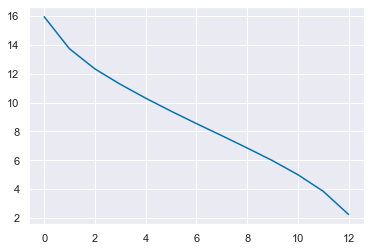

In [342]:
enc_layer = encoder.get_layer(index=-1)
enc_layer.activation = tf.keras.activations.linear

a = encoder.predict(X_test.values)
a.sort(axis=1)
a=a[ :,::-1]
a = pd.DataFrame(a)
a.mean(axis=0).plot()

In [343]:
# a.mean(axis=0)

In [344]:
# (a.mean(axis=0)/a.mean(axis=0).sum()).cumsum().head(50)

In [159]:
# enc_layer = encoder.get_layer("dense_23")

In [160]:
# enc_layer.kernel.eval()

In [345]:
losses.sort_index().tail(50)

,encoding_dim,hidden_size,num_epochs,val_loss,val_acc,val_mean_squared_error,val_binary_accuracy,val_binary_crossentropy,val_kullback_leibler_divergence,loss,acc,mean_squared_error,binary_accuracy,binary_crossentropy,kullback_leibler_divergence,mean_correlation,no_hidden_layers,elapsed_time,description
118,20.0,100.0,44.0,0.102921,0.722677,0.102368,0.897608,1.644755,1716.073744,0.102694,0.720723,0.102156,0.897823,1.641708,1726.051935,0.243098,1.0,183.394490,loss=mean_absolute_error
119,20.0,100.0,3.0,277389.665491,0.000000,0.128206,0.871793,2.066391,2503.231606,286399.363535,0.000000,0.128203,0.871797,2.066337,2502.991832,NaN,1.0,29.326678,loss=mean_absolute_percentage_error
120,20.0,100.0,27.0,0.064600,0.000000,0.064178,0.916787,0.221291,176.994842,0.063959,0.000142,0.063540,0.917610,0.219205,172.080184,0.368851,1.0,116.591669,loss=mean_squared_error
121,20.0,100.0,30.0,0.033327,0.000867,0.069399,0.910052,0.238361,208.444195,0.033039,0.001091,0.069240,0.910435,0.238412,213.981970,0.325796,1.0,145.870343,loss=mean_squared_logarithmic_error
122,20.0,100.0,31.0,0.273079,0.003755,0.065633,0.913053,0.221113,169.259972,0.269727,0.003225,0.064585,0.914045,0.216962,164.879672,0.385081,1.0,139.527981,loss=poisson
123,1.0,100.0,4.0,0.298572,0.887277,0.087912,0.887277,0.298268,236.787979,0.298957,0.887139,0.088031,0.887139,0.298652,237.305112,NaN,1.0,37.031118,loss=binary_crossentropy
124,2.0,100.0,19.0,0.261573,0.898452,0.077341,0.898452,0.261052,207.635348,0.260954,0.898645,0.077181,0.898645,0.260437,202.419710,0.247135,1.0,104.285965,loss=binary_crossentropy
125,4.0,100.0,23.0,0.261607,0.898580,0.077264,0.898580,0.260975,205.456631,0.260854,0.898809,0.077076,0.898809,0.260228,202.105204,0.247796,1.0,120.709904,loss=binary_crossentropy
126,8.0,100.0,22.0,0.233916,0.909208,0.068994,0.909208,0.233170,186.962297,0.231885,0.909654,0.068515,0.909654,0.231149,178.730302,0.340013,1.0,120.115870,loss=binary_crossentropy
127,16.0,100.0,32.0,0.222665,0.913674,0.065535,0.913674,0.221720,167.213685,0.219983,0.914423,0.064872,0.914423,0.219042,169.417089,0.369451,1.0,167.180562,loss=binary_crossentropy


In [31]:
autoencoder.get_layer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 1214)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 800)               972000    
_________________________________________________________________
dense_19 (Dense)             (None, 528)               422928    
_________________________________________________________________
dense_20 (Dense)             (None, 348)               184092    
_________________________________________________________________
dense_21 (Dense)             (None, 229)               79921     
_________________________________________________________________
dense_22 (Dense)             (None, 151)               34730     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               15200     
__________

In [34]:
# enc_layer = autoencoder.get_layer("dense_23")

In [124]:

# enc_layer.kernel.eval()

In [125]:
# with tf.variable_scope("dense_23", reuse=True):
#     weights = tf.get_variable("kernel")

In [176]:
# ['adam','SGD','RMSprop','Nadam','Ftrl','Adamax','Adagrad','Adadelta']

In [267]:
losses.to_csv("losses.csv")

In [278]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_162 (InputLayer)       (None, 1214)              0         
_________________________________________________________________
dense_268 (Dense)            (None, 100)               121500    
_________________________________________________________________
dense_269 (Dense)            (None, 20)                2020      
_________________________________________________________________
dense_tied_25 (DenseTied)    (None, 100)               2100      
_________________________________________________________________
dense_tied_26 (DenseTied)    (None, 1214)              122614    
Total params: 248,234
Trainable params: 124,834
Non-trainable params: 123,400
_________________________________________________________________


In [279]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_162 (InputLayer)       (None, 1214)              0         
_________________________________________________________________
dense_268 (Dense)            (None, 100)               121500    
_________________________________________________________________
dense_269 (Dense)            (None, 20)                2020      
Total params: 123,520
Trainable params: 123,520
Non-trainable params: 0
_________________________________________________________________


In [280]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_163 (InputLayer)       (None, 20)                0         
_________________________________________________________________
dense_tied_25 (DenseTied)    (None, 100)               2100      
_________________________________________________________________
dense_tied_26 (DenseTied)    (None, 1214)              122614    
Total params: 124,714
Trainable params: 1,314
Non-trainable params: 123,400
_________________________________________________________________


In [104]:
no_hidden_layers=2

In [108]:
no_hidden_layers=1
x = pow(X.shape[1]/encoding_dim,1/ (no_hidden_layers+1) )
[int(encoding_dim*pow(x,y)) for y in range(1,no_hidden_layers+1)]

[155]

[78, 308]

In [29]:
autoencoder.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_mean_squared_error', 'val_binary_accuracy', 'val_binary_crossentropy', 'val_kullback_leibler_divergence', 'loss', 'acc', 'mean_squared_error', 'binary_accuracy', 'binary_crossentropy', 'kullback_leibler_divergence'])

In [37]:
[encoding_dim,hidden_size]+[autoencoder.history.epoch[-1]]+[x[-1] for x in autoencoder.history.history.values()]+[mean_correlation]

[1,
 100,
 64,
 0.27131484921700577,
 0.8961409856794428,
 0.07960969625210383,
 0.8961409856794428,
 0.26936356308486636,
 210.38707410273324,
 0.26962507869432495,
 0.8966525362614849,
 0.07913072642145837,
 0.8966525362614849,
 0.26766992999040295,
 209.23708025020343,
 0.19572854614677257]

In [33]:
X_test_reconst.apply(lambda x: (X_test_reconst>.5)[x.name].corr( X_test[x.name] ) ).mean()  

0.3331904894686003

In [34]:
X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean()  

0.2974576615220296

In [43]:
df = pd.DataFrame(X_test_reconst>.5,columns=enc.get_feature_names()[not_low_var_columns],index=prep.index)

In [67]:
list(enc.get_feature_names()[not_low_var_columns]).index("x1_Conservative")

7

In [78]:
df = (X_test_reconst>.5).astype(int)
df.columns = enc.get_feature_names()[not_low_var_columns]

In [52]:
search(df,"Conservative")

x1_Conservative    0
dtype: int64

In [56]:
df_orig = pd.DataFrame(X_test,columns=enc.get_feature_names()[not_low_var_columns],index=prep.index)

In [82]:
df_orig = X_test.copy()
df_orig.columns = enc.get_feature_names()[not_low_var_columns]
df_orig = df_orig.astype(int)

In [83]:
df_orig["x1_Conservative"].sum()

3168

In [84]:
df["x1_Conservative"].sum()

3286

In [85]:
df["x1_Conservative"].corr(df_orig["x1_Conservative"])

0.6572463463950309

In [86]:
X_test_reconst[7].corr(X_test[7])

0.7163260426942462

In [89]:
sum(df["x1_Conservative"]==df_orig["x1_Conservative"])/df["x1_Conservative"].shape[0]

0.8530572941742899

In [23]:
X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean()

0        0.035615
1        0.019917
2        0.005073
3        0.365039
4        0.029809
           ...   
10380    0.019235
10381    0.005803
10382    0.020040
10383    0.006591
10384    0.006595
Name: 0, Length: 10385, dtype: float32

In [94]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,0].reshape(X_test.shape[0]),index=X_test.index)).sort_values().tail(50)

444    0.654178
650    0.663619
220    0.664292
899    0.667243
480    0.671782
73     0.673374
716    0.673770
468    0.677780
208    0.680285
832    0.683550
502    0.689561
292    0.690762
133    0.692577
513    0.694370
963    0.694707
243    0.695602
563    0.695610
887    0.698197
808    0.698532
765    0.698603
820    0.700747
492    0.703564
254    0.704982
525    0.705057
722    0.706938
346    0.710535
271    0.711914
262    0.712888
547    0.713450
853    0.715295
935    0.715577
278    0.716758
536    0.721971
619    0.722107
557    0.724030
232    0.728334
595    0.729707
911    0.730417
642    0.732571
568    0.734126
607    0.734949
157    0.737945
551    0.740737
841    0.741016
946    0.744880
145    0.748310
583    0.754455
631    0.757446
923    0.797876
99     0.820750
dtype: float64

In [95]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,0].reshape(X_test.shape[0]),index=X_test.index))

0       0.628757
1       0.054209
2       0.146042
3       0.216294
4      -0.434844
          ...   
1209    0.317695
1210   -0.042881
1211   -0.471164
1212    0.000535
1213   -0.378133
Length: 1214, dtype: float64

In [134]:
# column_indices = [int(x.split("_")[0].split("x")[1]) for x in enc.get_feature_names()]

# [prep.columns[x] for x in column_indices]



In [165]:
X_test_reconst.columns = enc.get_feature_names()[not_low_var_columns]
X_test_reconst.columns = [prep.columns[int(x.split("_")[0].split("x")[1])] +"_"+"_".join(x.split("_")[1:]) for x in enc.get_feature_names()[not_low_var_columns]]

In [171]:
pd.Series(encoded_imgs[:,0].reshape(X_test.shape[0]),index=X_test.index)

0        12.683509
1         6.415140
2        10.448038
3        15.592491
4         9.604498
           ...    
10380     8.139466
10381     7.947016
10382    16.281174
10383     8.983170
10384    15.389397
Length: 10385, dtype: float32

In [178]:
X_test_reconst

,turnoutUKGeneral_Don't know,turnoutUKGeneral_Fairly likely,turnoutUKGeneral_Fairly unlikely,turnoutUKGeneral_Neither likely nor unlikely,turnoutUKGeneral_Very likely that I would vote,turnoutUKGeneral_Very unlikely that I would vote,partyId_Brexit Party,partyId_Conservative,partyId_Don't know,partyId_Green Party,...,p_socgrade_D,p_socgrade_E,p_work_stat_Full time student,p_work_stat_Not working,p_work_stat_Other,p_work_stat_Retired,p_work_stat_Unemployed,p_work_stat_Working full time (30 or more hours per week),p_work_stat_Working part time (8-29 hours a week),p_work_stat_Working part time (Less than 8 hours a week)
0,0.026282,0.068805,0.001629,0.015137,0.892816,0.003156,1.760394e-04,0.019917,0.085475,5.693115e-03,...,0.050275,0.063551,5.314280e-10,0.000012,0.000013,0.999966,0.000016,2.452791e-06,0.000036,0.000277
1,0.001169,0.011621,0.000689,0.001358,0.991844,0.000106,6.609153e-03,0.899560,0.003529,6.822440e-08,...,0.110335,0.036535,5.503378e-02,0.436184,0.171925,0.000195,0.033771,9.844662e-02,0.200591,0.058534
2,0.005467,0.023903,0.004019,0.002716,0.916311,0.024182,6.235079e-07,0.000130,0.019660,1.517888e-01,...,0.051451,0.055892,1.146598e-02,0.085408,0.062280,0.000163,0.063275,5.957812e-01,0.123466,0.024368
3,0.448947,0.175972,0.159889,0.090295,0.255069,0.035474,7.446283e-03,0.052941,0.521693,7.538813e-03,...,0.251277,0.152827,5.735501e-02,0.099913,0.158661,0.000360,0.153525,1.465451e-01,0.182566,0.027022
4,0.026569,0.263455,0.044833,0.011535,0.610052,0.044484,3.267425e-06,0.101332,0.108201,2.429532e-02,...,0.057373,0.010448,4.877146e-03,0.025902,0.030927,0.000144,0.009883,7.347320e-01,0.182867,0.006657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10380,0.001532,0.009261,0.000446,0.001950,0.991826,0.001690,2.124070e-03,0.964805,0.008298,1.519304e-04,...,0.105821,0.049481,7.320977e-06,0.009616,0.004506,0.914321,0.001067,1.413699e-02,0.026630,0.002234
10381,0.000533,0.005337,0.002443,0.000546,0.991706,0.001901,2.297399e-07,0.001788,0.004791,2.109569e-02,...,0.045792,0.021381,7.100905e-04,0.080619,0.027517,0.024338,0.019940,4.547871e-01,0.139068,0.019919
10382,0.003727,0.017923,0.000749,0.001268,0.979195,0.001425,3.125064e-03,0.966488,0.002681,1.134562e-04,...,0.036809,0.060820,3.036134e-10,0.000003,0.000003,0.999992,0.000009,1.536834e-07,0.000007,0.000409
10383,0.001878,0.104837,0.001077,0.005400,0.878496,0.003679,1.229488e-04,0.000219,0.032745,6.617742e-02,...,0.205676,0.110111,3.917053e-05,0.438405,0.095926,0.057841,0.137630,1.401684e-02,0.259046,0.107334


In [ ]:
## just the p_ dataset

In [347]:
get_top_corr(df[0],50)
## nan pattern

p_scot_const_vote_2016_nan                                                                                          -0.770571
p_scot_list_vote_2016_nan                                                                                           -0.770555
p_turnout_scot_ref_nan                                                                                              -0.764552
p_scot_const_vote_2016_I would/did not vote                                                                          0.682897
p_scot_list_vote_2016_I would/did not vote                                                                           0.682838
p_turnout_scot_ref_No, I did not vote                                                                                0.632320
p_turnout_scot_ref_Don't know                                                                                        0.336103
p_socgrade_Unknown                                                                                                   0

In [349]:
get_top_corr(df[1],50)
#+: non-voting, private renting,  non-cohabit relationship, hh_childnren=1/_size=3, read no newspaper, private sector,
# Black and White caribbean/african, live with parents
#-: voting, retired, home-owning, methodist|baptist|United Reformed Church, reads "Other newspaper"|mirror|express,
# Labour|Conservatiove, 10-15k personal income, 

p_turnout_2015_Yes, I voted                                                                 -0.707584
p_past_vote_2005_nan                                                                         0.689842
p_turnout_2015_No, I did not vote                                                            0.684054
p_turnout_2005_Yes, I voted                                                                 -0.664326
p_past_vote_2010_nan                                                                         0.662034
p_past_vote_2015_nan                                                                         0.657338
p_turnout_2010_Yes, I voted                                                                 -0.653989
p_past_vote_2017_nan                                                                         0.609389
p_turnout_2017_No, I did not vote                                                            0.602627
p_turnout_2017_Yes, I voted                                                       

In [350]:
get_top_corr(df[2],50)
#+: ed age<=15/16, no formal quals, local auth/housing assoc renter, reads Sun|Star, disabled, Leave, retired, grade E, BNP
    # voted2005, £5-15k, White British, ed-pref not to say/other technical, Conservative
#-: ed age>=20, undergrad, degree, A-level, reads Independent, grade B|C1, £35-45k, Remain, house part-own, Full-time,
    # non-cohab relationship, White and Asian, public sector, born East Asia, 


p_education_age_15 or under                                                                                          0.597808
p_edlevel_Undergraduate                                                                                             -0.507154
p_education_University or CNAA first degree (e.g. BA, B.Sc, B.Ed)                                                   -0.496835
p_edlevelUni_No qualifications                                                                                       0.485831
p_education_No formal qualifications                                                                                 0.485829
p_edlevel_No qualifications                                                                                          0.485828
p_education_age_16                                                                                                   0.447748
p_edlevelUni_Undergraduate                                                                                          -0

In [351]:
get_top_corr(df[3],50)
#+: non-scot, ed_age 16, 5-15k, GCE/O-level/A-level
#-: ScotrefVoted, £35-100k, reads Scotsman, Scotref_No, postgrad/degree/ed_age 20+, presby/Brethren, born East Asia/Oceania,
    #SNP/Conservative,Full-time work, Own with mortgage,
    # 

p_scot_const_vote_2016_nan                                        0.461897
p_scot_list_vote_2016_nan                                         0.461401
p_turnout_scot_ref_nan                                            0.458204
p_vote_scot_ref_nan                                               0.426041
p_turnout_scot_ref_Yes, I voted                                  -0.423957
p_gross_personal_Â Â£45,000 to Â£49,999 per year                 -0.413802
p_education_age_16                                                0.378848
p_paper_read_The Scotsman                                        -0.365590
p_vote_scot_ref_Voted no                                         -0.363920
p_edlevelUni_Postgrad                                            -0.360375
p_education_University or CNAA higher degree (e.g. M.Sc, Ph.D)   -0.360344
p_edlevel_Postgrad                                               -0.360254
p_religion_Yes - Presbyterian/Church of Scotland                 -0.359602
p_gross_personal_Â Â£10,0

In [352]:
get_top_corr(df[4],50)

p_turnout_scot_ref_nan                                                                                                                          -0.617804
p_scot_const_vote_2016_nan                                                                                                                      -0.617531
p_scot_list_vote_2016_nan                                                                                                                       -0.617323
p_religion_Yes - Evangelical â independent/non-denominational (e.g. FIEC, Pioneer, Vineyard, Newfrontiers)                                    -0.482446
p_scot_const_vote_2016_I would/did not vote                                                                                                      0.478374
p_scot_list_vote_2016_I would/did not vote                                                                                                       0.477434
p_turnout_scot_ref_No, I did not vote                                       

In [353]:
get_top_corr(df[5],50)

# scotref!

p_turnout_scot_ref_nan                                                                                              -0.423568
p_scot_const_vote_2016_nan                                                                                          -0.413284
p_scot_list_vote_2016_nan                                                                                           -0.412933
p_turnout_scot_ref_Yes, I voted                                                                                      0.407464
p_vote_scot_ref_nan                                                                                                 -0.407288
p_religion_Yes â Orthodox Christian                                                                               -0.396735
p_socgrade_B                                                                                                        -0.396266
p_vote_scot_ref_Voted no                                                                                             0

In [354]:
get_top_corr(df[6],50)
# uber-conservative/leave/mail/express axis/ white british/born UK/Methodist/voted2019/UKIP/outright homeowner
# guardian/independent/other ethnic group/born elsewhere/Labour/private renter/bisexual/other religion/orthodox Christian

p_past_vote_2019_Conservative                                     0.701294
p_past_vote_2017_Conservative                                     0.680624
p_past_vote_2010_Conservative                                     0.638922
p_paper_read_The Daily Mail / The Scottish Daily Mail             0.614752
p_past_vote_2005_Conservative                                     0.570727
p_past_vote_2015_Conservative                                     0.547804
p_eurefvote_I voted to leave                                      0.513850
p_paper_read_The Independent                                     -0.480487
p_paper_read_The Express                                          0.474537
p_religion_Yes - Church of England/Anglican/Episcopal             0.427913
p_ethnicity_White British                                         0.416971
p_past_vote_2005_nan                                             -0.416825
p_turnout_2010_Yes, I voted                                       0.415651
p_past_vote_2019_Labour  

In [355]:
get_top_corr(df[7],50)
#+:ed_age <=15/16,anglican,parent,voted2015,married,
#-:undergrad/degree/private rent/bisexual,single,

p_education_age_16                                                                                              0.472629
p_edlevel_Undergraduate                                                                                        -0.450170
p_education_University or CNAA first degree (e.g. BA, B.Sc, B.Ed)                                              -0.411080
p_edlevelUni_Undergraduate                                                                                     -0.404643
p_religion_Yes - Church of England/Anglican/Episcopal                                                           0.375162
p_housing_Rent â from a private landlord                                                                     -0.371351
p_sexuality_Bisexual                                                                                           -0.367192
p_parent_Yes                                                                                                    0.363614
p_turnout_2015_Yes, I voted     

In [ ]:
## Full dataset

In [308]:
df[0][ df[0].abs().sort_values(ascending=False).head(50).index ]
# ~70s homeowners, retired, no risk unemploy, not furloughed, no income change, no risk povery, employed medium/big org, voted2005, no high risk close family
# vs ~30s, hhsize =3/6, private renting, close family hospitalised

p_housing_Own â outright                                  0.786232
age_68.0                                                    0.678903
riskUnemployment_Very unlikely                              0.660571
workingStatus_Retired                                       0.655966
p_work_stat_Retired                                         0.655218
age_67.0                                                    0.647165
incomeGuaranteeHH_none_Yes                                  0.640425
age_70.0                                                    0.636616
age_69.0                                                    0.633559
age_72.0                                                    0.621873
workingStatusPartner_Retired                                0.619201
prevJobPartner_Yes, they have done paid work in the past    0.616997
partnerOccStatusLast_nan                                   -0.615147
incomeGuaranteeHH_1_No                                      0.608516
partnerOccOrgSizeLast_25 to 499 em

In [309]:
get_top_corr(df[1],50)
# leave voting, lab would handle corona/economic badly, tax_spend_5, immig bad for culture, Not Scotland??
# vs pro-imm, non-Eng id, likes greens, Remain/rejoin id, reduced cv infections, BXP vote unlikely, disagree too many handouts, taxSpend pro spending
    # lrLD/SNP =5


immigSelf_7                                    -0.552508
euPriorityBalance_1                            -0.548200
englishness_Not at all English                 -0.544114
euRefVoteAfter_Rejoin the EU                   -0.531103
likeGrn_8                                      -0.527043
p_eurefvote_I voted to remain                  -0.525392
cvEconSelf_1                                   -0.523984
euID_The remain side                           -0.523822
taxSpendSelf_5                                  0.521696
ptvBrexitParty_Very unlikely                   -0.521051
europeanness_6                                 -0.518159
govtHandouts_Disagree                          -0.512335
lrLD_5                                         -0.510665
handleCoronaLab_Very badly                      0.510516
ptvGrn_6                                       -0.503089
likeFarage_Strongly dislike                    -0.502992
reasonForUnemployment_Agree                    -0.499408
likeBrexitParty_Strongly dislik

In [311]:
get_top_corr(df[2],50)
#+: retired+no sector, disability, personal high medical risk, 70s, pref not to answer gross income
#-: full-time work, unemployment fairly unlikely, employee/supervisor midsize/arge org, homeworking due to corona,
# pub/third/private sector, mid-high income, somewhat worried about close ppl catching corona, ~40s, no disability, mortgage


p_work_stat_Working full time (30 or more hours per week)                                                           -0.649722
p_job_sector_Not applicable                                                                                          0.648587
riskUnemployment_Fairly unlikely                                                                                    -0.637485
p_disability_Yes, limited a little                                                                                   0.633070
workHomeCoronaSelf_nan                                                                                               0.627598
selfOccSupervise_Yes                                                                                                -0.626090
selfOccOrgSize_25 to 499 employees                                                                                  -0.622827
selfOccStatus_An employee                                                                                           -0

In [312]:
get_top_corr(df[3],50)
# nan structure

labPriorities_nhs_nan             0.780948
grnPriorities_immig_nan           0.780942
labPriorities_immig_nan           0.780934
selfPriorities_brexit_nan         0.780922
labPriorities_crime_nan           0.780917
grnPriorities_crime_nan           0.780916
selfPriorities_environment_nan    0.780914
ldPriorities_immig_nan            0.780911
ldPriorities_crime_nan            0.780908
ldPriorities_none_nan             0.780904
empathy2_nan                      0.780903
empathy1_nan                      0.780900
conPriorities_brexit_nan          0.780897
ldPriorities_environment_nan      0.780897
conPriorities_nhs_nan             0.780897
labPriorities_brexit_nan          0.780897
labUnited_nan                     0.780897
selfPriorities_econ_nan           0.780896
grnPriorities_econ_nan            0.780896
selfPriorities_immig_nan          0.780894
conPriorities_environment_nan     0.780891
empathy7_nan                      0.780891
ldPriorities_nhs_nan              0.780890
empathy9_na

In [313]:
get_top_corr(df[4],50)
# more nan structure

labPriorities_brexit_nan         -0.839870
grnPriorities_crime_nan          -0.839866
conPriorities_environment_nan    -0.839859
grnPriorities_environment_nan    -0.839858
ldPriorities_brexit_nan          -0.839854
empathy7_nan                     -0.839854
conPriorities_nhs_nan            -0.839852
ldPriorities_crime_nan           -0.839849
empathy3_nan                     -0.839849
ldPriorities_econ_nan            -0.839848
empathy8_nan                     -0.839848
ldPriorities_immig_nan           -0.839848
labPriorities_crime_nan          -0.839848
labPriorities_nhs_nan            -0.839847
conUnited_nan                    -0.839846
empathy10_nan                    -0.839846
selfPriorities_brexit_nan        -0.839845
empathy9_nan                     -0.839844
taxSpendLab_nan                  -0.839844
ldPriorities_none_nan            -0.839842
conPriorities_econ_nan           -0.839842
empathy2_nan                     -0.839841
labPriorities_none_nan           -0.839839
selfPriorit

In [314]:
get_top_corr(df[5],50)
# more nan structure?

selfPriorities_environment_Yes    0.697996
selfPriorities_nhs_Yes            0.690536
selfPriorities_none_No            0.679228
selfPriorities_crime_No           0.677486
empathy6_Agree                    0.676660
grnPriorities_none_nan           -0.674575
labPriorities_crime_nan          -0.674571
empathy7_nan                     -0.674565
ldPriorities_nhs_nan             -0.674561
grnPriorities_immig_nan          -0.674561
labPriorities_immig_nan          -0.674558
taxSpendCon_nan                  -0.674546
labPriorities_environment_nan    -0.674544
labPriorities_nhs_nan            -0.674541
ldPriorities_none_nan            -0.674541
conPriorities_brexit_nan         -0.674540
selfPriorities_nhs_nan           -0.674535
empathy2_nan                     -0.674534
selfPriorities_brexit_nan        -0.674532
labPriorities_none_nan           -0.674531
selfPriorities_econ_nan          -0.674530
empathy8_nan                     -0.674529
conPriorities_econ_nan           -0.674528
empathy5_na

In [315]:
get_top_corr(df[6],50)
#
#

p_housing_Own â with a mortgage                                                                                0.529203
occCheckPartner_Neither well nor badly                                                                           0.520993
partnerOccStatus_nan                                                                                            -0.514612
workHomeCoronaPartner_nan                                                                                       -0.511200
partnerOccOrgSize_nan                                                                                           -0.504480
partnerOccSupervise_nan                                                                                         -0.503451
sectorPartner_nan                                                                                               -0.502854
partnerOccStatus_An employee                                                                                     0.498644
occCheckPartner_Fairly w

In [316]:
get_top_corr(df[7],50)
#+: Don't knows
#-: infoSourceTV 1-2 hrs
#

infoSourceTV_1 to 2 hours                     -0.701122
al_scale_nan                                   0.678569
handleCoronaLab_Don't know                     0.608109
goodTimePurchase_Don't know                    0.601875
changeEconomyLab_Don't know                    0.597636
deficitReduce_Don't know                       0.582722
euID2_Don't know                               0.579977
cutsTooFarLocal_Don't know                     0.579897
immigSelf_Don't know                           0.578926
redistSelf_Don't know                          0.574034
mii_Don't know                                 0.566482
changeNHSLab_Don't know                        0.566120
occCheckPartner_Very well                     -0.565757
cutsTooFarNational_Don't know                  0.565350
econPersonalProsp_Don't know                   0.561657
goodTimePurchase_Good time to buy             -0.561505
euPriorityBalance_Don't know                   0.560491
riskPoverty_Don't know                         0

In [318]:
get_top_corr(df[8],50)
# nans

labUnited_Fairly divided         -0.505080
resourceAccess1_4_No              0.503924
resourceAccess1_5_No              0.503911
empathy6_nan                      0.502427
labPriorities_brexit_nan          0.502397
taxSpendLab_nan                   0.502393
taxSpendCon_nan                   0.502385
empathy4_nan                      0.502379
ldPriorities_environment_nan      0.502377
selfPriorities_nhs_nan            0.502367
ldPriorities_econ_nan             0.502363
selfPriorities_immig_nan          0.502362
grnPriorities_crime_nan           0.502361
grnPriorities_environment_nan     0.502361
ldPriorities_brexit_nan           0.502358
empathy3_nan                      0.502357
grnPriorities_brexit_nan          0.502356
conPriorities_brexit_nan          0.502356
grnPriorities_nhs_nan             0.502351
conPriorities_environment_nan     0.502350
conPriorities_immig_nan           0.502349
conPriorities_crime_nan           0.502349
selfPriorities_econ_nan           0.502344
selfPriorit

In [319]:
get_top_corr(df[9],50)
# nans

globalFilms_nan                 0.701993
resourceAccess1_4_nan           0.701982
globalTourism_nan               0.701960
resourceAccess3_5_nan           0.701941
resourceAccess2_3_nan           0.701936
resourceAccess1_5_nan           0.701930
globalBanks_nan                 0.701911
resourceAccess1_2_nan           0.701897
populism5_nan                   0.701881
resourceAccess1_1_nan           0.701870
globalOrgs_nan                  0.701868
globalBrands_nan                0.701847
dealPriorityImmig_nan           0.701841
resourceAccess3_1_nan           0.701834
globalMigration_nan             0.701826
resourceAccess2_2_nan           0.701814
dealPriorityMarketAccess_nan    0.701812
dealPriorityTradeDeal_nan       0.701808
dealPriorityNIUKBorder_nan      0.701806
resourceAccess3_3_nan           0.701805
dealPriorityNIEireBorder_nan    0.701802
resourceAccess3_8_nan           0.701798
resourceAccess1_3_nan           0.701798
resourceAccess3_111_nan         0.701797
resourceAccess3_

In [320]:
get_top_corr(df[10],50)

p_turnout_scot_ref_nan                                         0.595812
p_scot_const_vote_2016_nan                                     0.590065
lrLD_4                                                         0.589640
p_scot_list_vote_2016_nan                                      0.589561
responsibleEconC_4_nan                                         0.580547
englishness_5                                                  0.547252
globalGoodOverall_Slightly more good than bad                  0.533117
p_turnout_scot_ref_Yes, I voted                               -0.532020
scotReferendumIntention_nan                                    0.530974
EUIntegrationSNP_nan                                           0.530936
immigSNP_nan                                                   0.530871
scottishness_nan                                               0.530857
scotgovtHandlelockdown_nan                                     0.530804
redistSNP_nan                                                  0

In [321]:
get_top_corr(df[11],50)

lifeAnxiety_6                  -0.558538
benchCoronaUSA_8               -0.539851
lifeAnxiety_3                  -0.527134
gor_East Midlands              -0.525275
lockdownApproval_9             -0.514542
lifeWorthwhile_7               -0.513535
benchCoronaUSA_6               -0.509061
achieveReduceImmigGrn_nan       0.507836
benchCoronaGermany_nan          0.507776
conLookAfterMC_nan              0.507742
lifeHappy_nan                   0.507736
conLookAfterBA_nan              0.507735
achieveReduceImmigLab_nan       0.507728
lifeAnxiety_nan                 0.507727
noneuMore_nan                   0.507716
studentsMore_nan                0.507714
lockdownApproval_nan            0.507705
achieveReduceImmigCon_nan       0.507701
lifeWorthwhile_nan              0.507700
conLookAfterWC_nan              0.507700
achieveReduceImmigLD_nan        0.507697
benchCoronaItaly_nan            0.507697
lifeSat_nan                     0.507693
labLookAfterMC_nan              0.507690
labLookAfterLoca

In [324]:
get_top_corr(df[12],50)

benchCoronaUK_nan              -0.707874
achieveReduceImmigLD_nan       -0.707863
benchCoronaItaly_nan           -0.707859
lifeWorthwhile_nan             -0.707854
studentsMore_nan               -0.707853
labLookAfterBA_nan             -0.707845
achieveReduceImmigNone_nan     -0.707840
govtCorpSupport_nan            -0.707839
euMore_nan                     -0.707831
lockdownApproval_nan           -0.707828
lifeHappy_nan                  -0.707816
lifeSat_nan                    -0.707814
labLookAfterWC_nan             -0.707809
benchCoronaGermany_nan         -0.707802
labLookAfterMC_nan             -0.707800
conLookAfterMC_nan             -0.707796
familiesMore_nan               -0.707784
noneuMore_nan                  -0.707782
conLookAfterLocal_nan          -0.707781
benchCoronaChina_nan           -0.707781
conLookAfterWC_nan             -0.707781
benchCoronaSweden_nan          -0.707771
conLookAfterBA_nan             -0.707765
achieveReduceImmigLab_nan      -0.707762
achieveReduceImm

In [346]:
df = pd.DataFrame(encoded_imgs,index=X_test.index).apply(lambda x: X_test_reconst.corrwith(x))
def get_top_corr(x,n):
    return x[x.abs().sort_values(ascending=False).head(n).index]

In [196]:
df[0][ df[0].abs().sort_values(ascending=False).head(25).index ]
# Don't know - Confident no family members/you/anyone else have had covid (gender effect?)/No coronavirus measures

coronaMeasures2_1_Don't know       0.550226
coronaMeasures2_3_Don't know       0.550170
coronaMeasures2_5_Don't know       0.550068
coronaMeasures2_4_Don't know       0.550045
coronaMeasures2_2_Don't know       0.550027
coronaMeasures2_none_Don't know    0.549936
CVsuspect_2_No                    -0.531197
coronaMeasures_3_Don't know        0.513401
coronaMeasures_4_Don't know        0.513352
coronaMeasures_1_Don't know        0.513288
coronaMeasures_none_Don't know     0.513149
coronaMeasures_2_Don't know        0.513046
coronaMeasures_5_Don't know        0.512908
CVsuspect_3_No                    -0.503928
CVsuspect_1_No                    -0.501164
CVsuspect_1_Don't know             0.487141
CVsuspect_3_Don't know             0.487011
CVsuspect_none_Don't know          0.486918
CVsuspect_2_Don't know             0.486703
coronaMeasures_none_No            -0.473092
coronaMeasures2_none_No           -0.463824
handleCoronaLab_Don't know         0.463266
CVsuspect_none_Yes              

In [199]:
get_top_corr(df[1],25)
# Distrust of Westminster/MPs vs Trust in Cons

cvEconCon_6                            -0.688102
trustWestminster_Hardly ever            0.687664
redistCon_7                            -0.684287
cutsTooFarNational_About right         -0.671857
changeNHS_Getting a little better      -0.671314
cutsTooFarLocal_About right            -0.670410
cvEconCon_4                            -0.667997
trustMPs_5                             -0.666614
privateEnterprise_Agree                -0.665972
changeCorona_Getting a little better   -0.663242
govtHandlelockdown_Fairly well         -0.660928
satDemUK_Fairly satisfied              -0.655041
stateOwnership_Disagree                -0.654610
trustMPs_No trust                       0.634541
immigCon_3                             -0.630897
econGenProsp_Get a little better       -0.629679
immigCon_4                             -0.626459
redistCon_8                            -0.624745
trustWestminster_Most of the time      -0.621122
redistCon_6                            -0.620576
govtHandlelockdown_V

In [200]:
get_top_corr(df[2],25)
# Have - haven't close association with people who received High Risk medical letter/warning over covid

highRiskLetter_none_Yes               0.778212
highRiskMedical_2_No                  0.750209
highRiskLetter_2_No                   0.734286
highRiskMedical_none_Yes              0.719088
highRiskLetter_1_No                   0.655405
highRiskMedical_3_No                  0.639717
highRiskLetter_3_No                   0.637021
highRiskMedical_none_No              -0.620084
highRiskMedical_2_Yes                -0.610146
highRiskMedical_3_Yes                -0.568944
highRiskLetter_none_Don't know       -0.520123
highRiskLetter_3_Don't know          -0.519916
highRiskLetter_1_Don't know          -0.519783
highRiskLetter_2_Don't know          -0.519746
highRiskLetter_none_No               -0.516865
highRiskLetter_2_Yes                 -0.464457
highRiskMedical_1_No                  0.460814
hhIncomeCorona_It hasnât changed    0.416328
econPersonalRetro_Stayed the same     0.407240
highRiskLetter_3_Yes                 -0.387332
riskPoverty_Very unlikely             0.372800
stoppedWork_n

In [202]:
get_top_corr(df[4],25)
# euID/Farage/BrexitParty/uni/social grade B/anti-death penalty vs euID Leave/reads-Sun/strongLeader-meh

strongLeader_Strongly disagree                   0.655867
likeFarage_Strongly dislike                      0.650051
likeBrexitParty_Strongly dislike                 0.641124
euID_The remain side                             0.637734
ptvBrexitParty_Very unlikely                     0.631503
p_socgrade_B                                     0.611143
europeanness_5                                   0.592283
anyUni_Yes, I graduated from higher education    0.591506
govtHandleTesting_Very badly                     0.584465
govtHandlePPE_Very badly                         0.574851
changeNHS_Getting a little worse                 0.574542
al2_Strongly disagree                            0.573118
changeNHSLab_Getting a little better             0.568268
govtHandleTesting_Neither well nor badly        -0.553404
handleCorona_Very badly                          0.551782
lrBrexit_Right                                   0.549213
euPriorityBalance_Access to the single market    0.542629
strongLeader_N

In [204]:
get_top_corr(df[5],25)
# hhIncomeCorona reduction/you someone you know stopped work/lost inc - age+/hhIncomeCorona static/retired/economy stayed same/unemployment unlikely/no suspicion anyone close had corona

hhIncomeCorona_It hasnât changed                       -0.494369
riskUnemployment_Very unlikely                           -0.486108
CVsuspect_2_No                                           -0.475616
hhIncomeCorona_It has decreased by less than a quarter    0.468423
CVsuspect_none_Yes                                       -0.462144
CVsuspect_1_No                                           -0.460938
incomeGuaranteeHH_1_No                                   -0.456845
workingStatus_Retired                                    -0.456381
stoppedWork_none_Yes                                     -0.455247
p_work_stat_Retired                                      -0.454683
age_71                                                   -0.443369
age_72                                                   -0.431269
age_70                                                   -0.430865
stoppedWork_none_No                                       0.423570
CVsuspect_3_No                                           -0.42

In [205]:
get_top_corr(df[6],25)
# Full-time-work/thinks Lab prioritises corona-lives&equal inc, choose midpoint - vs choose Don't know/9pt

workingStatus_Working full time (30 or more hours per week)     0.421246
p_work_stat_Working full time (30 or more hours per week)       0.420120
cvEconLab_Reduce infections even if it damages the economy      0.380577
taxSpendSelf_5                                                  0.376896
immigGreen_5                                                    0.371459
immigLD_5                                                       0.371012
cvEconGreen_5                                                   0.369274
cvEconLD_5                                                      0.364810
lrCon_9                                                        -0.357915
EUIntegrationLD_5                                               0.353120
redistLab_Government should try to make incomes equal           0.350736
EUIntegrationGreen_5                                            0.349741
cvEconLD_Don't know                                            -0.342789
redistGreen_5                                      

In [206]:
get_top_corr(df[7],25)
# corona impacted work income/lr(2,3,4))_Agree,taxSpend_6,private_enterprise_meh - corona didn't stop work/income increased/unemployment unlikely

hhIncomeCorona_It has decreased by less than a quarter    0.607958
stoppedWork_none_No                                       0.587603
stoppedWork_none_Yes                                     -0.520345
lr5_Agree                                                 0.511632
stoppedWork_1_Yes                                         0.484172
cutsTooFarNational_Gone too far                           0.480439
cutsTooFarLocal_Gone too far                              0.480037
lr3_Agree                                                 0.473937
riskUnemployment_Fairly unlikely                          0.461531
enviroGrowth_6                                            0.455721
enviroGrowth_7                                            0.445782
workingStatus_Furloughed                                  0.441500
riskUnemployment_Very unlikely                           -0.432269
incomeGuaranteePersonal_1_Yes                             0.424251
incomeGuaranteePersonal_none_No                           0.42

In [208]:
get_top_corr(df[8],25)
# economy got/getting/will get a *lot* worse, extremely worried corona,likeStarmer_8/9/10,cutsTooFar,ptvLab - economy "" little worse

changeEconomy_Getting a lot worse            0.592138
econGenProsp_Get a lot worse                 0.590368
econGenRetro_Got a lot worse                 0.570157
CVsuspect_2_No                              -0.531043
econGenProsp_Get a little worse             -0.530275
changeEconomy_Getting a little worse        -0.514678
infoSourceTV_More than 2 hours               0.510635
worryCoronaEcon_Extremely Worried            0.507561
CVsuspect_none_Yes                          -0.503805
EUIntegrationCon_Protect our independence    0.489529
cutsTooFarNational_Gone much too far         0.488843
econGenRetro_Got a little worse             -0.485964
cutsTooFarLocal_Gone much too far            0.484045
likeStarmer_8                                0.483296
govtHandleTesting_Very badly                 0.483073
changeNHSLab_Getting a lot better            0.482269
polAttention_4                              -0.480688
cutsTooFarNHS_Gone much too far              0.473051
likeStarmer_Strongly like   

In [209]:
get_top_corr(df[9],25)
# not close to anyone who got corona, don't like BrexitParty/Farage, BXP right-wing - dk if close to anyone with corona, might vote BXP

CVsuspect_3_No                               0.514502
CVsuspect_2_No                               0.514354
CVsuspect_1_No                               0.503344
CVsuspect_none_Yes                           0.502846
CVsuspect_none_Don't know                   -0.429322
CVsuspect_2_Don't know                      -0.429129
CVsuspect_1_Don't know                      -0.428836
CVsuspect_3_Don't know                      -0.428684
EUIntegrationBrexit_9                       -0.423184
EUIntegrationCon_Protect our independence    0.415230
ptvBrexitParty_Very unlikely                 0.409423
ptvBrexitParty_4                            -0.392260
immigBrexit_1                               -0.389623
likeBrexitParty_Strongly dislike             0.387132
likeFarage_Strongly dislike                  0.386308
EUIntegrationBrexit_8                       -0.380594
englishness_Not at all English               0.373203
EUIntegrationCon_6                          -0.371104
immigBrexit_2               

In [210]:
get_top_corr(df[10],25)
# euID_leave, economy/corona would get worse under Labour/immigration easier, --Grn/LD/Lab, read Daily Mail, Labour is 100% Left and Remaniac ,
# al1_Strongly Agree (young people don't respect British values), partyId Conservative, economy>environment

changeEconomyLab_Getting a lot worse                     0.802300
EUIntegrationSelf_Protect our independence               0.776345
euID_The leave side                                      0.758531
handleCoronaLab_Very badly                               0.751310
ptvGrn_Very unlikely                                     0.721619
immigLab_Allow many more                                 0.713875
ptvLab_Very unlikely                                     0.712468
ptvLD_Very unlikely                                      0.708794
immigLD_Allow many more                                  0.685142
englishness_Very strongly English                        0.675288
europeanness_Not at all European                         0.670248
enviroGrowth_1                                           0.669772
lrLab_Left                                               0.665712
likeLab_Strongly dislike                                 0.662669
p_paper_read_The Daily Mail / The Scottish Daily Mail    0.661287
likeGrn_1 

In [211]:
get_top_corr(df[11],25)
# corona corona corona, taxSpend_8

coronaMeasures_2_Yes                   -0.716609
coronaMeasures_1_Yes                   -0.650252
coronaMeasures2_4_Yes                  -0.628380
coronaMeasures_none_No                 -0.620231
coronaMeasures_3_Yes                   -0.608989
coronaMeasures_5_Yes                   -0.593171
worryCoronaHealth_9                    -0.570092
coronaMeasures2_3_Yes                  -0.558818
worryCoronaHealth_8                    -0.547268
coronaMeasures_4_Yes                   -0.541211
cvFreedomSelf_1                        -0.539517
cvEconSelf_1                           -0.535471
coronaMeasures2_2_Yes                  -0.528506
taxSpendSelf_8                         -0.513163
cvEconSelf_2                           -0.504099
coronaMeasures2_none_No                -0.501433
coronaMeasures_5_Don't know             0.492976
coronaMeasures_1_Don't know             0.492856
coronaMeasures_4_Don't know             0.492814
coronaMeasures_3_Don't know             0.492804
coronaMeasures_2_Don

In [212]:
get_top_corr(df[12],25)
# Don't know, infoSourceInternet_no time at all, 

redistBrexit_Don't know                    0.767557
redistGreen_Don't know                     0.739776
cvEconLab_Don't know                       0.719144
immigGreen_Don't know                      0.717229
EUIntegrationGreen_Don't know              0.705557
cvEconGreen_Don't know                     0.704848
redistLD_Don't know                        0.700134
immigGreen_7                              -0.672637
cvEconGreen_2                             -0.664483
lrgreens_Don't know                        0.663569
redistLab_Don't know                       0.662800
cvEconLD_Don't know                        0.659428
immigGreen_6                              -0.656258
immigLD_Don't know                         0.656234
redistCon_Don't know                       0.652503
redistGreen_3                             -0.642872
EUIntegrationLD_Don't know                 0.634853
infoSourceInternet_None, no time at all    0.628721
cvEconLab_3                               -0.626237
immigGreen_8

In [326]:
gc.collect()

81203

In [327]:
search(BES_Panel,"p_")

p_country_birth            30185
p_disability               30600
p_parent                   30246
p_education_age            30880
p_education                31467
p_ethnicity                30595
p_gross_household          31322
p_gross_personal           31215
p_housing                  31029
p_hh_children              31451
p_hh_size                  31418
p_marital                  31458
p_paper_read               31468
p_religion                 30822
p_socgrade                 31468
p_work_stat                31468
p_sexuality                31385
p_job_sector               30237
p_past_vote_2010           18369
p_past_vote_2005           16900
p_past_vote_2015           24274
p_past_vote_2017           26528
p_past_vote_2019           27406
p_turnout_2015             31428
p_turnout_2017             31428
p_turnout_2019             31427
p_scot_const_vote_2011      1797
p_scot_list_vote_2011       1796
p_scot_const_vote_2016     10615
p_scot_list_vote_2016      10613
p_welsh_co

In [328]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12
turnoutUKGeneral_Very unlikely that I would vote,-0.236947,0.177413,0.157256,-0.054205,0.120385,0.083779,-0.118898,0.303134,0.167073,0.041571,-0.279152,0.094278,0.139209
turnoutUKGeneral_Fairly unlikely,-0.337272,0.278706,0.058517,-0.101755,0.057110,0.062471,0.009589,0.255385,0.090679,0.029718,-0.222033,0.037819,0.078585
turnoutUKGeneral_Neither likely nor unlikely,-0.367201,0.261790,0.090037,0.006119,-0.075366,-0.032600,0.145760,0.186271,0.072137,-0.074257,-0.285596,-0.020201,0.034576
turnoutUKGeneral_Fairly likely,-0.319877,0.190954,-0.028230,0.011027,-0.135650,-0.096444,0.290400,0.244906,0.144465,-0.022689,-0.085472,-0.051500,0.187596
turnoutUKGeneral_Very likely that I would vote,0.392646,-0.270720,-0.134109,0.080401,-0.009932,-0.000994,-0.108757,-0.422857,-0.185752,0.007824,0.335409,-0.024042,-0.175593
...,...,...,...,...,...,...,...,...,...,...,...,...,...
p_edlevelUni_Postgrad,0.107065,-0.124383,-0.307136,0.101098,-0.031434,0.181101,-0.026054,0.019323,-0.201830,-0.296885,0.346832,0.116367,0.018520
p_edlevelUni_nan,-0.251879,0.236580,0.333037,-0.152071,-0.055970,-0.200888,0.157552,0.246497,-0.023160,0.059652,-0.375752,-0.104221,0.063057
"p_eurefturnout_No, did not vote",-0.457870,0.101078,0.037618,0.020139,0.008691,-0.000676,-0.175276,0.345817,0.016945,-0.160716,-0.229426,0.168838,0.169613
"p_eurefturnout_Yes, voted",0.485778,-0.096666,-0.029699,0.009239,-0.024647,-0.007325,0.143888,-0.394860,-0.013592,0.168663,0.283893,-0.169200,-0.164037


In [170]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,0].reshape(X_test.shape[0]),index=X_test.index))

#.sort_values().tail(50)

turnoutUKGeneral_Don't know                                  0.283392
turnoutUKGeneral_Fairly likely                               0.086054
turnoutUKGeneral_Fairly unlikely                             0.047981
turnoutUKGeneral_Neither likely nor unlikely                 0.145107
turnoutUKGeneral_Very likely that I would vote              -0.191907
                                                               ...   
p_work_stat_Retired                                          0.075151
p_work_stat_Unemployed                                      -0.090194
p_work_stat_Working full time (30 or more hours per week)    0.001419
p_work_stat_Working part time (8-29 hours a week)            0.014475
p_work_stat_Working part time (Less than 8 hours a week)    -0.047571
Length: 1214, dtype: float64

In [168]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,0].reshape(X_test.shape[0]),index=X_test.index)).sort_values().head(50)

CVsuspect_2_No                                                 -0.531197
CVsuspect_3_No                                                 -0.503928
CVsuspect_1_No                                                 -0.501164
coronaMeasures_none_No                                         -0.473092
coronaMeasures2_none_No                                        -0.463824
CVsuspect_none_Yes                                             -0.459717
coronaMeasures2_1_Yes                                          -0.417432
dutyCorona_Strongly agree                                      -0.414517
coronaMeasures2_2_Yes                                          -0.414013
coronaMeasures_1_Yes                                           -0.406641
coronaMeasures2_3_Yes                                          -0.400371
coronaMeasures_5_Yes                                           -0.399973
coronaMeasures_2_Yes                                           -0.391816
coronaMeasures2_4_Yes                              

In [130]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,1].reshape(X_test.shape[0]),index=X_test.index)).sort_values().tail(50)[::-1]

age_65                                                   0.904639
riskUnemployment_Very unlikely                           0.893336
age_75                                                   0.857434
econPersonalRetro_Stayed the same                        0.856699
goodTimePurchase_Good time to buy                        0.856290
age_67                                                   0.855261
age_70                                                   0.848664
age_66                                                   0.846267
workingStatus_Retired                                    0.842629
p_work_stat_Retired                                      0.841223
econPersonalProsp_Stay the same                          0.830294
age_64                                                   0.815917
riskPoverty_Very unlikely                                0.813887
highRiskLetter_2_No                                      0.811187
age_76                                                   0.801478
age_72    

In [131]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,1].reshape(X_test.shape[0]),index=X_test.index)).sort_values().head(50)[::-1]

CVsuspect_3_Yes                                                   -0.650074
schoolKidsInHouse_Yes                                             -0.651308
age_20                                                            -0.654047
workingStatus_Working part time (8-29 hours per week)             -0.660043
age_49                                                            -0.662118
age_46                                                            -0.664993
workingStatus_Unemployed and looking for work                     -0.668164
hhIncomeCorona_It has decreased by between a quarter and a half   -0.668531
britishness_3                                                     -0.669285
riskPoverty_Fairly likely                                         -0.675077
age_19                                                            -0.678619
workingStatus_Working part time (less than 8 hours a week)        -0.680917
age_29                                                            -0.681383
goodTimePurc

In [132]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,2].reshape(X_test.shape[0]),index=X_test.index)).sort_values().tail(50)[::-1]

oslaua_Fife                                                                                              0.623511
coronaMeasures_3_Yes                                                                                     0.595159
coronaMeasures2_4_Yes                                                                                    0.579838
coronaMeasures_5_Yes                                                                                     0.569108
coronaMeasures_4_Yes                                                                                     0.565062
econGenProsp_Get a lot worse                                                                             0.553613
coronaMeasures_2_Yes                                                                                     0.550925
hhIncomeCorona_It hasnât changed                                                                       0.550922
changeCorona_Getting a little worse                                                     

In [133]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,2].reshape(X_test.shape[0]),index=X_test.index)).sort_values().head(50)[::-1]

cvFreedomSelf_4                                              -0.526710
riskScale_11                                                 -0.528682
cutsTooFarNHS_Not gone far enough                            -0.529841
age_54                                                       -0.530344
econGenProsp_Get a little better                             -0.530582
taxSpendSelf_2                                               -0.530844
age_48                                                       -0.534833
govtHandlePPE_Neither well nor badly                         -0.538408
cvEconSelf_5                                                 -0.539286
taxSpendSelf_5                                               -0.540484
incomeGuaranteeHH_none_No                                    -0.541871
CVsuspect_1_Yes                                              -0.547116
cvEconSelf_8                                                 -0.548531
trustMPs_A great deal of trust                               -0.550170
econGe

In [135]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,3].reshape(X_test.shape[0]),index=X_test.index)).sort_values().tail(50)[::-1]

oslaua_Cheshire West and Chester                     0.729736
hhIncomeCorona_It hasnât changed                   0.684927
CVsuspect_1_No                                       0.677660
cvFreedomSelf_3                                      0.677598
econPersonalProsp_Stay the same                      0.664683
oslaua_Cheshire East                                 0.662123
CVsuspect_none_Yes                                   0.660222
p_socgrade_B                                         0.642704
econPersonalRetro_Stayed the same                    0.634463
sickElderlyInHouse_No                                0.630819
genTrust_Most people can be trusted                  0.618685
riskPoverty_Very unlikely                            0.611798
worryCoronaEcon_8                                    0.605018
riskPoverty_Fairly unlikely                          0.585642
stoppedWork_none_Yes                                 0.582851
highRiskLetter_none_Yes                              0.581500
cvFreedo

In [136]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,3].reshape(X_test.shape[0]),index=X_test.index)).sort_values().head(50)[::-1]

lrLab_Right                                                           -0.573150
taxSpendSelf_1                                                        -0.576427
worryCoronaPub_Extremely Worried                                      -0.577033
p_work_stat_Other                                                     -0.578440
lr5_Strongly agree                                                    -0.579112
redistGreen_Government should be less concerned about equal incomes   -0.579589
coronaMeasures_1_No                                                   -0.581196
p_socgrade_D                                                          -0.581672
riskPoverty_Neither likely nor unlikely                               -0.582956
EUIntegrationBrexit_Unite fully with the European Union               -0.584273
lrCon_Left                                                            -0.586864
econGenRetro_Stayed the same                                          -0.587240
hhIncomeCorona_It has decreased by betwe

In [125]:
# tensorflow.python.keras.models

In [ ]:
# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias=True,
#                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)) 
# decoder = Dense(input_dim, activation="linear", use_bias = True,
#                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=1))

# autoencoder = Sequential()
# autoencoder.add(encoder)
# autoencoder.add(decoder)

# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='sgd')
# autoencoder.summary()

# autoencoder.fit(X_train_scaled, X_train_scaled,
#                 epochs=nb_epoch,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 verbose=0)

In [ ]:
# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage = 1.)) 
# decoder = Dense(input_dim, activation="linear", use_bias = True)

# autoencoder = Sequential()
# autoencoder.add(encoder)
# autoencoder.add(decoder)

# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='sgd')
# autoencoder.summary()

# autoencoder.fit(X_train_scaled, X_train_scaled,
#                 epochs=nb_epoch,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 verbose=0)

In [ ]:
# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, kernel_constraint=UnitNorm(axis=0)) 
# decoder = Dense(input_dim, activation="linear", use_bias = True, kernel_constraint=UnitNorm(axis=1))
# autoencoder = Sequential()
# autoencoder.add(encoder)
# autoencoder.add(decoder)
# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='sgd')
# autoencoder.summary()
# autoencoder.fit(X_train_scaled, X_train_scaled,
#                 epochs=nb_epoch,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 verbose=0)

In [272]:

# encoder.use_bias


# kernel_initializer

In [263]:
# input_dim =32

# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,)) 
# decoder = DenseTied(input_dim, activation="linear", tied_to=encoder)
# autoencoder = Sequential()
# autoencoder.add(encoder)
# autoencoder.add(decoder)
# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='sgd')
# autoencoder.summary()
# # autoencoder.fit(X_train_scaled, X_train_scaled,
# #                 epochs=nb_epoch,
# #                 batch_size=batch_size,
# #                 shuffle=True,
# #                 verbose=0)

In [4]:
# encoder.kernel

In [ ]:
## DATA PROCESSING BUG: p_gross_personal__Â Prefer not to answer

In [71]:
search(BES_Panel,"Johnson")

likeJohnson    31468
dtype: int64

In [74]:
search(BES_Panel,"wt")

wt              31468
enviroGrowth    31468
dtype: int64

In [80]:
round(pd.crosstab(BES_Panel["likeJohnson"],BES_Panel["polAttention"], values=BES_Panel["wt"],aggfunc=sum,normalize='columns')*100,2)

polAttention,Pay no attention,1,2,3,4,5,6,7,8,9,Pay a great deal of attention,Don't know
likeJohnson,,,,,,,,,,,,
Strongly dislike,20.69,12.44,13.71,14.97,16.11,14.88,17.02,21.41,23.73,30.70,37.86,15.19
1,3.45,4.01,4.59,3.28,3.98,4.13,5.77,5.98,7.31,7.25,5.40,3.05
2,3.40,5.75,6.08,5.57,6.21,5.73,6.51,6.37,7.03,6.38,4.72,5.05
3,4.53,5.89,7.83,5.58,6.54,7.03,7.39,6.84,5.36,4.48,3.51,1.88
4,1.95,6.00,6.98,8.70,8.07,6.14,6.87,4.94,4.80,4.23,2.97,1.65
5,12.65,16.31,16.00,11.53,13.44,14.58,10.05,8.40,6.51,5.50,5.51,8.22
6,4.37,11.58,7.65,10.11,11.17,9.38,10.33,7.82,6.66,5.46,4.00,4.96
7,6.76,9.20,10.97,12.18,11.12,12.18,12.56,12.56,10.26,9.13,5.83,3.49
8,4.26,5.83,7.13,9.56,8.63,8.73,9.98,11.64,12.08,9.21,8.31,2.52
